# 📊 Ablation Study: XAI Methods for RL-based Inventory Management
---

**Agents**: DQN (Double DQN, Per-Product Q-Network) vs A2C_mod (Actor-Critic)  
**XAI Methods**: RDX (Reward Decomposition), MSX (Minimal Sufficient Explanation), SHAP  
**Environment**: 220 products, 14 discrete actions, reward = `1 - z - overstock - q - quan`

### Experiment Grid
| Dimension | Values |
|---|---|
| Agent | DQN, A2C_mod |
| Scenario | EASY, MEDIUM, HARD |
| XAI Config | RDX_only, SHAP_only, Combined |
| λ (MSX threshold) | 0.5, 1.0, 1.5, 2.0 |

### Metrics
- **OCS** (Objective Coverage Score): fraction of objectives with |ΔQ^k| > θ_Q
- **FCS** (Feature Coverage Score): fraction of features with |SHAP| > θ_φ
- **CAS** (Cross-domain Alignment Score): Jaccard similarity between top SHAP features and top RDX objectives
- **Stability**: % MSX set change when λ varies

## Step 1: Setup & Khởi tạo Agent (Restore Checkpoints)

In [23]:
import os, warnings, time
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa   # DQN checkpoint uses tfa.layers.GroupNormalization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(edgeitems=10, linewidth=10000, precision=6, suppress=True)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print(f"TensorFlow: {tf.__version__}")
print(f"NumPy: {np.__version__}")

TensorFlow: 2.14.0
NumPy: 1.24.3


In [24]:
# ============================================================
# CONFIGURATION
# ============================================================
NUM_PRODUCTS    = 220
NUM_FEATURES_PP = 3          # per product: [x, sales, q]
NUM_FEATURES    = NUM_PRODUCTS * NUM_FEATURES_PP  # 660
NUM_ACTIONS     = 14
ACTION_SPACE    = np.array([0, 0.005, 0.01, 0.0125, 0.015, 0.0175,
                            0.02, 0.03, 0.04, 0.08, 0.12, 0.2, 0.5, 1],
                           dtype=np.float32)
WASTE_RATE      = 0.025
ZERO_INVENTORY  = 1e-5
GAMMA           = 0.99

# Architecture sizes
DQN_HIDDEN  = 128
A2C_HIDDEN  = 32
DROPOUT     = 0.1

# Paths
DATA_DIR        = 'data220'
TEST_FILE       = os.path.join(DATA_DIR, 'test.tfrecords')
CAP_FILE        = os.path.join(DATA_DIR, 'capacity.tfrecords')
STOCK_FILE      = os.path.join(DATA_DIR, 'stock.tfrecords')
DQN_CKPT_DIR    = 'checkpoints_dqn_comparison3primary'
A2C_CKPT_DIR    = 'outputA2Cmod/checkpoints_a2cmod'

# Reward component identifiers
OBJECTIVES = ['stockout', 'overstock', 'waste', 'quantile']
FEATURES   = ['inventory', 'sales', 'waste_feat']  # 3 input features

print("Configuration ✓")

Configuration ✓


### 1.1 Model Architecture Declarations

In [25]:
# ============================================================
# A2C_mod Model Classes — from training1.py
# ============================================================
# Key: Critic uses tf.keras.layers.GroupNormalization(groups=1)
#      Actor has 4 Dense layers → softmax
#      Both use hidden_size=32, dropout=0.1

class Dense(tf.Module):
    def __init__(self, input_dim, output_size, activation=None, stddev=1.0):
        super(Dense, self).__init__()
        self.w = tf.Variable(
            tf.random.truncated_normal([input_dim, output_size], stddev=stddev), name='w')
        self.b = tf.Variable(tf.zeros([output_size]), name='b')
        self.activation = activation

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        if self.activation:
            y = self.activation(y)
        return y


class Actor(tf.Module):
    """Policy network: [P, 3] → [P, 14] softmax probabilities."""
    def __init__(self, num_features, num_actions, hidden_size,
                 activation=tf.nn.relu, dropout_prob=0.1):
        super(Actor, self).__init__()
        self.layer1 = Dense(num_features, hidden_size, activation=None)
        self.layer2 = Dense(hidden_size, hidden_size, activation=None)
        self.layer3 = Dense(hidden_size, hidden_size, activation=None)
        self.layer4 = Dense(hidden_size, num_actions, activation=None)
        self.activation = activation
        self.dropout_prob = dropout_prob

    def __call__(self, state):
        x = self.activation(self.layer1(state))
        x = tf.nn.dropout(x, self.dropout_prob)
        x = self.activation(self.layer2(x))
        x = tf.nn.dropout(x, self.dropout_prob)
        x = self.activation(self.layer3(x))
        x = tf.nn.dropout(x, self.dropout_prob)
        x = self.layer4(x)
        return tf.nn.softmax(x)


class Critic(tf.Module):
    """Value network: [P, 3] → [P] scalar values. Uses GroupNorm."""
    def __init__(self, num_features, hidden_size,
                 activation=tf.nn.relu, dropout_prob=0.1):
        super(Critic, self).__init__()
        self.layer1 = Dense(num_features, hidden_size, activation=None)
        self.layer2 = Dense(hidden_size, 1, activation=None)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.group_norm = tf.keras.layers.GroupNormalization(groups=1)

    def __call__(self, state):
        x = self.layer1(state)
        x = self.group_norm(x)
        x = self.activation(x)
        x = tf.nn.dropout(x, self.dropout_prob)
        x = self.layer2(x)
        return tf.squeeze(x, axis=-1, name='factor_squeeze')

print("A2C_mod classes (Dense, Actor, Critic) defined ✓")

A2C_mod classes (Dense, Actor, Critic) defined ✓


In [26]:
# ============================================================
# DQN Model Class — from dqn_a2c_comparison.ipynb
# Per-Product Q-Network: [B, 660] → reshape → [B*220, 3] → MLP → [B, 220, 14]
# ============================================================

class MultiProductQNetwork(tf.keras.Model):
    """
    Per-Product Q-Network. Each product processed independently.
    Input:  [B, 660]  (flattened: [x_0..x_P, sales_0..sales_P, q_0..q_P])
    Output: [B, 220, 14]
    """
    def __init__(self, num_features, num_products, num_actions,
                 hidden_size, dropout_prob=0.1, use_group_norm=True, name=None):
        super().__init__(name=name)
        self.num_products      = num_products
        self.num_actions       = num_actions
        self.features_per_prod = num_features // num_products  # 3

        self.dense1 = tf.keras.layers.Dense(hidden_size, activation=None, name="dense1")
        self.dense2 = tf.keras.layers.Dense(hidden_size, activation=None, name="dense2")
        self.dense3 = tf.keras.layers.Dense(hidden_size, activation=None, name="dense3")
        self.out    = tf.keras.layers.Dense(num_actions,  activation=None, name="output")

        self._use_gn = use_group_norm
        if use_group_norm:
            self.gn1 = tfa.layers.GroupNormalization(groups=1, name="gn1")
            self.gn2 = tfa.layers.GroupNormalization(groups=1, name="gn2")
            self.gn3 = tfa.layers.GroupNormalization(groups=1, name="gn3")

        self.drop1 = tf.keras.layers.Dropout(dropout_prob)
        self.drop2 = tf.keras.layers.Dropout(dropout_prob)
        self.drop3 = tf.keras.layers.Dropout(dropout_prob)

    def call(self, state, training=False):
        B = tf.shape(state)[0]
        P, F = self.num_products, self.features_per_prod
        # [B, 660] → [B, 3, 220] → [B, 220, 3]
        s3d = tf.transpose(tf.reshape(state, [B, F, P]), [0, 2, 1])
        x = tf.reshape(s3d, [B * P, F])

        x = self.dense1(x)
        if self._use_gn: x = self.gn1(x, training=training)
        x = tf.nn.relu(x); x = self.drop1(x, training=training)

        x = self.dense2(x)
        if self._use_gn: x = self.gn2(x, training=training)
        x = tf.nn.relu(x); x = self.drop2(x, training=training)

        x = self.dense3(x)
        if self._use_gn: x = self.gn3(x, training=training)
        x = tf.nn.relu(x); x = self.drop3(x, training=training)

        return tf.reshape(self.out(x), [B, P, self.num_actions])

print("DQN class (MultiProductQNetwork) defined ✓")

DQN class (MultiProductQNetwork) defined ✓


### 1.2 Load Checkpoints

In [27]:
# ============================================================
# load_trained_agents(): Restore both agents from disk
# ============================================================

def load_trained_agents():
    """Load DQN and A2C_mod agents from checkpoints."""

    # ── A2C_mod ──────────────────────────────────────────────
    actor  = Actor(NUM_FEATURES_PP, NUM_ACTIONS, A2C_HIDDEN,
                   activation=tf.nn.relu, dropout_prob=DROPOUT)
    critic = Critic(NUM_FEATURES_PP, A2C_HIDDEN,
                    activation=tf.nn.relu, dropout_prob=DROPOUT)
    # Build with dummy pass
    _d = tf.zeros([1, NUM_FEATURES_PP])
    _ = actor(_d); _ = critic(_d)

    a2c_ckpt = tf.train.Checkpoint(
        critic_optimizer=tf.optimizers.Adam(0.0005),
        actor_optimizer=tf.optimizers.Adam(0.0001),
        critic=critic, actor=actor, step=tf.Variable(0))
    a2c_ckpt.restore(tf.train.latest_checkpoint(A2C_CKPT_DIR))#.expect_partial()
    print(f"✅ A2C_mod restored: {tf.train.latest_checkpoint(A2C_CKPT_DIR)}")

    # ── DQN ──────────────────────────────────────────────────
    q_net = MultiProductQNetwork(
        NUM_FEATURES, NUM_PRODUCTS, NUM_ACTIONS,
        DQN_HIDDEN, DROPOUT, use_group_norm=True, name="q_network")
    t_net = MultiProductQNetwork(
        NUM_FEATURES, NUM_PRODUCTS, NUM_ACTIONS,
        DQN_HIDDEN, DROPOUT, use_group_norm=True, name="target_network")
    _d = tf.zeros([1, NUM_FEATURES], dtype=tf.float32)
    _ = q_net(_d, training=False); _ = t_net(_d, training=False)

    dqn_ckpt = tf.train.Checkpoint(
        optimizer=tf.optimizers.Adam(0.001),
        q_network=q_net, target_network=t_net,
        step=tf.Variable(0, dtype=tf.int64))
    dqn_ckpt.restore(tf.train.latest_checkpoint(DQN_CKPT_DIR))#.expect_partial()
    print(f"✅ DQN restored: {tf.train.latest_checkpoint(DQN_CKPT_DIR)}")

    return {'actor': actor, 'critic': critic, 'q_network': q_net}

agents = load_trained_agents()

✅ A2C_mod restored: outputA2Cmod/checkpoints_a2cmod\ckpt-64
✅ DQN restored: checkpoints_dqn_comparison3primary\ckpt-50


### 1.3 Load Test Data

In [28]:
# ============================================================
# Load TFRecord test data
# ============================================================
def _parse(serialized, key, n):
    return tf.io.parse_single_example(
        serialized, {key: tf.io.FixedLenFeature([n], tf.float32)})[key]

capacity = next(iter(
    tf.data.TFRecordDataset(CAP_FILE).map(lambda s: _parse(s, 'capacity', NUM_PRODUCTS))
)).numpy()

x_init = next(iter(
    tf.data.TFRecordDataset(STOCK_FILE).map(lambda s: _parse(s, 'stock', NUM_PRODUCTS))
)).numpy()

all_sales = []
for rec in tf.data.TFRecordDataset(TEST_FILE).map(lambda s: _parse(s, 'sales', NUM_PRODUCTS)):
    all_sales.append(rec.numpy())
all_sales = np.array(all_sales, dtype=np.float32) / capacity[None, :]
T_MAX = len(all_sales)
print(f"✅ Test data: {T_MAX} timesteps × {NUM_PRODUCTS} products")

✅ Test data: 604 timesteps × 220 products


## Step 2: XAI Module — RDX, MSX, SHAP

### 2.1 RDX (Reward Decomposition eXplanation)

Phân rã Q-value/Advantage thành 4 thành phần dựa trên cấu trúc reward:
$$r = \underbrace{1}_{base} - \underbrace{z}_{stockout} - \underbrace{overstock}_{overstock} - \underbrace{q}_{waste} - \underbrace{quan}_{quantile}$$

**ΔQ^k**: Chênh lệch Q-value component k giữa action tốt nhất và action thay thế.

In [29]:
# ============================================================
# RDX: Reward Decomposition — using get_decomposed_reward
# ============================================================
# Reward formula: r = (1 - z) - overstock - q - quan
#   service = 1 - z         (service level: +1 if in stock, 0 if stockout)
#   holding = -overstock    (holding cost penalty)
#   waste   = -q            (waste penalty)
#   order   = -quan         (quantile spread penalty)

def get_decomposed_reward(x_vec, u_vec):
    """
    Vectorized reward decomposition for P products.
    Tính 4 sub-rewards (signed) cho một cặp (state, action).

    Args:
        x_vec: np.ndarray [P] — inventory levels (normalized)
        u_vec: np.ndarray [P] — order quantities (from ACTION_SPACE)

    Returns:
        dict[str, np.ndarray[P]]: 4 signed sub-rewards
              positive = good, negative = penalty
    """
    z         = (x_vec < ZERO_INVENTORY).astype(np.float32)       # [P]
    overstock = np.maximum(0, x_vec + u_vec - 1.0)                # [P]
    q         = WASTE_RATE * x_vec                                # [P]
    quan_val  = float(np.quantile(x_vec, 0.95) - np.quantile(x_vec, 0.05))
    quan      = np.full(NUM_PRODUCTS, quan_val, dtype=np.float32) # [P]

    r_service = 1.0 - z          # service level reward
    r_holding = -overstock       # holding cost penalty
    r_waste   = -q               # waste penalty
    r_order   = -quan            # order variability penalty

    return {
        'stockout':  r_service,    # → r_service = 1 - z
        'overstock': r_holding,    # → r_holding = -overstock
        'waste':     r_waste,      # → r_waste   = -q
        'quantile':  r_order,      # → r_order   = -quan
    }


def rdx_dqn(q_network, state_flat, x_vec):
    """
    RDX for DQN: Decompose Q-value difference into 4 objective contributions.

    For each product i:
      a* = argmax_a Q(s, a)_i
      a' = second-best action for product i
      ΔQ^k = r^k(s, a*) - r^k(s, a')   (immediate reward difference)

    Note: stockout, waste, quantile chỉ phụ thuộc state (không đổi theo action)
          → hiệu = 0. Phần ΔQ còn lại (residual) được phân bổ tỷ lệ theo penalty.

    Returns:
        delta_q: dict[str, np.ndarray[P]] — ΔQ^k per objective per product
        best_actions: np.ndarray[P] — indices of best actions
    """
    q_vals = q_network(state_flat[None, :], training=False)[0].numpy()  # [P, A]
    best_a  = np.argmax(q_vals, axis=1)    # [P]

    # Second-best action
    q_masked = q_vals.copy()
    q_masked[np.arange(NUM_PRODUCTS), best_a] = -np.inf
    second_a = np.argmax(q_masked, axis=1)  # [P]

    u_best   = ACTION_SPACE[best_a]
    u_second = ACTION_SPACE[second_a]

    # Decomposed rewards for both actions
    r_best   = get_decomposed_reward(x_vec, u_best)
    r_second = get_decomposed_reward(x_vec, u_second)

    # ΔQ^k = r^k(a*) - r^k(a')
    # stockout: (1-z) - (1-z) = 0  (same state → same z)
    # overstock: (-os_best) - (-os_second) = os_second - os_best  ← trực tiếp
    # waste:    (-q) - (-q) = 0  (same state → same waste)
    # quantile: (-quan) - (-quan) = 0  (same state → same quantile)
    delta_q = {obj: r_best[obj] - r_second[obj] for obj in OBJECTIVES}

    # Residual: phần ΔQ chưa giải thích bởi immediate reward difference
    # (stockout/waste/quantile ảnh hưởng qua next-state γV(s'), không trực tiếp)
    q_best   = q_vals[np.arange(NUM_PRODUCTS), best_a]
    q_second = q_vals[np.arange(NUM_PRODUCTS), second_a]
    q_diff   = q_best - q_second                # [P] total ΔQ
    explained = delta_q['overstock']             # chỉ overstock có hiệu ≠ 0
    residual  = q_diff - explained

    # Distribute residual UNIFORMLY among state-dependent objectives
    # (Avoid "myopic" weighting based on current penalties, as this ignores
    #  DQN's ability to anticipate future states via γV(s'))
    n_state_objectives = 3  # stockout, waste, quantile (exclude overstock)
    uniform_share = residual / n_state_objectives

    delta_q['stockout'] += uniform_share
    delta_q['waste']    += uniform_share
    delta_q['quantile'] += uniform_share

    # Return q_gap for MSX computation
    q_gap = q_diff  # [P] - Q-value difference between best and second-best
    return delta_q, best_a, q_gap


# def rdx_a2c(actor, state_pp, x_vec):
#     """
#     RDX for A2C: Decompose action preference into 4 objective contributions.

#     Compare best action vs second-best action (similar to DQN approach):
#       ΔQ^k = r^k(s, a*) - r^k(s, a')

#     Returns:
#         delta_q: dict[str, np.ndarray[P]] — ΔQ^k per objective per product
#         best_actions: np.ndarray[P] — indices of best actions
#     """
#     probs  = actor(state_pp).numpy()       # [P, A]
#     best_a = np.argmax(probs, axis=1)      # [P]

#     # Second-best action (mask out best action)
#     probs_masked = probs.copy()
#     probs_masked[np.arange(NUM_PRODUCTS), best_a] = -np.inf
#     second_a = np.argmax(probs_masked, axis=1)  # [P]

#     u_best   = ACTION_SPACE[best_a]
#     u_second = ACTION_SPACE[second_a]

#     # Decomposed rewards for both actions
#     r_best   = get_decomposed_reward(x_vec, u_best)
#     r_second = get_decomposed_reward(x_vec, u_second)

#     # ΔQ^k = r^k(a*) - r^k(a')
#     # Only overstock differs between actions (state-dependent components cancel out)
#     delta_q = {obj: r_best[obj] - r_second[obj] for obj in OBJECTIVES}
    
#     # For A2C: use sum of absolute differences as proxy for Q-gap
#     # (since A2C doesn't have explicit Q-values)
#     q_gap = np.sum([np.abs(delta_q[obj]) for obj in OBJECTIVES], axis=0)  # [P]
#     return delta_q, best_a, q_gap
def rdx_a2c(actor, critic, state_pp, x_vec):
    """Enhanced A2C RDX with critic-based Q-gap."""
    probs  = actor(state_pp).numpy()
    best_a = np.argmax(probs, axis=1)
    
    # Second-best action
    probs_masked = probs.copy()
    probs_masked[np.arange(NUM_PRODUCTS), best_a] = -np.inf
    second_a = np.argmax(probs_masked, axis=1)
    
    # ✅ USE CRITIC VALUE AS Q-GAP PROXY
    state_value = critic(state_pp).numpy()  # [P]
    
    # Estimate Q(s,a) ≈ V(s) + A(s,a)
    # For best action: A(s, a*) = max prob (higher advantage)
    # For second: A(s, a') = second prob
    prob_best = probs[np.arange(NUM_PRODUCTS), best_a]
    prob_second = probs[np.arange(NUM_PRODUCTS), second_a]
    
    # Use probability ratio as advantage proxy
    advantage_ratio = prob_best / (prob_second + 1e-8)
    q_gap = state_value * (advantage_ratio - 1.0)  # [P]
    
    # Decomposed rewards for both actions
    r_best   = get_decomposed_reward(x_vec, ACTION_SPACE[best_a])
    r_second = get_decomposed_reward(x_vec, ACTION_SPACE[second_a])

    # ΔQ^k = r^k(a*) - r^k(a')
    # Only overstock differs between actions (state-dependent components cancel out)
    delta_q = {obj: r_best[obj] - r_second[obj] for obj in OBJECTIVES}
    
    # ...rest of function...
    return delta_q, best_a, q_gap

print("RDX module defined ✓ (using get_decomposed_reward)")

print("RDX module defined ✓ (using get_decomposed_reward)")

RDX module defined ✓ (using get_decomposed_reward)
RDX module defined ✓ (using get_decomposed_reward)


## Cell thay thế cho cell trên

### 2.1 RDX Methodology: Model-Agnostic Approach

**Why Model-Agnostic?**

Traditional RDX decomposes learned Q-values into reward components. However, for cross-architecture comparison (DQN vs A2C):
- DQN learns Q(s,a) directly → can decompose Q-difference
- A2C learns V(s) and π(a|s) → must estimate Q(s,a) ≈ r + γV(s')
- **Problem**: Different scales, different approximation errors → unfair comparison

**Our Approach: Counterfactual Reward Decomposition**

Instead of decomposing learned Q-values, we:
1. Use agent ONLY to select actions (best vs 2nd-best)
2. Simulate 1-step trajectories for both actions (deterministic dynamics)
3. Compute reward components from **ground-truth reward function**
4. Compare: ΔQ^k = Reward^k(best) - Reward^k(second)

**Advantages for Inventory Domain**:
- ✅ Architecture-agnostic: fair DQN vs A2C comparison
- ✅ Deterministic dynamics → simulation is exact
- ✅ Explicit reward function → components directly computable
- ✅ Robust: not affected by Q-approximation quality
- ✅ Interpretable: "If agent chose differently, objective k would change by ΔQ^k"

**Applicability**: This approach is suitable for domains with:
- Known, deterministic (or near-deterministic) dynamics
- Structured, additive reward functions
- Need for cross-agent comparison

For opaque environments (games, robotics), traditional Q-based RDX is necessary.

In [30]:

# ============================================================
# RDX: Reward Decomposition với 1-STEP LOOKAHEAD
# ============================================================
# Reward formula: r = (1 - z) - overstock - q - quan
#   IMMEDIATE: overstock (trên current state + action)
#   FUTURE: stockout (z), waste (q), quantile (quan) — trên next state

def unified_rdx_1step(u_best, u_second, x_vec, sales_now, waste_rate, gamma=GAMMA):
    """
    Tính RDX với 1-step lookahead dynamics.
    
    Args:
        u_best: np.ndarray [P] — best actions (order quantities)
        u_second: np.ndarray [P] — second-best actions
        x_vec: np.ndarray [P] — current inventory levels
        sales_now: np.ndarray [P] — current sales/demand
        waste_rate: float — waste penalty rate
        gamma: float — discount factor (0.99)
    
    Returns:
        delta_q: dict[str, np.ndarray[P]] — ΔQ per objective
        q_gap: np.ndarray[P] — total Q-value difference
    """
    # ── STEP 1: Immediate Overstock Penalty (current state + action) ──
    overstock_best   = np.maximum(0, x_vec + u_best - 1.0)
    overstock_second = np.maximum(0, x_vec + u_second - 1.0)
    delta_overstock  = overstock_second - overstock_best  # Penalty diff
    
    # ── STEP 2: Next State Transition ──
    x_after_order_best   = np.clip(x_vec + u_best, 0, 1)
    x_after_order_second = np.clip(x_vec + u_second, 0, 1)
    
    x_next_best   = np.maximum(0, x_after_order_best - sales_now)
    x_next_second = np.maximum(0, x_after_order_second - sales_now)
    
    # ── STEP 3: Future Penalties (trên next state) ──
    # Stockout
    z_best   = (x_next_best < ZERO_INVENTORY).astype(np.float32)
    z_second = (x_next_second < ZERO_INVENTORY).astype(np.float32)
    delta_stockout = gamma * (z_second - z_best)  # Service loss diff
    
    # Waste
    q_best   = waste_rate * x_next_best
    q_second = waste_rate * x_next_second
    delta_waste = gamma * (q_second - q_best)  # Waste diff
    
    # Quantile spread (global metric, same for both → diff ≈ 0 usually)
    quan_best   = np.quantile(x_next_best, 0.95) - np.quantile(x_next_best, 0.05)
    quan_second = np.quantile(x_next_second, 0.95) - np.quantile(x_next_second, 0.05)
    delta_quantile_scalar = gamma * (quan_second - quan_best)
    delta_quantile = np.full(len(x_vec), delta_quantile_scalar, dtype=np.float32)
    
    # ── STEP 4: Assemble Delta Q Dictionary ──
    delta_q = {
        'stockout':  delta_stockout,   # positive → second-best causes more stockout
        'overstock': delta_overstock,  # positive → second-best causes more overstock
        'waste':     delta_waste,      # positive → second-best causes more waste
        'quantile':  delta_quantile,   # positive → second-best increases spread
    }
    
    # ── STEP 5: Compute Q-gap as sum of all ΔQ components ──
    q_gap = (delta_stockout + delta_overstock + delta_waste + delta_quantile)
    
    return delta_q, q_gap


def rdx_dqn(q_network, state_flat, x_vec, sales_now=None, waste_rate=WASTE_RATE):
    """
    RDX for DQN với 1-step lookahead.
    
    Args:
        q_network: MultiProductQNetwork model
        state_flat: np.ndarray [660] — flattened state
        x_vec: np.ndarray [P] — current inventory
        sales_now: np.ndarray [P] — sales/demand (extracted from state_flat if None)
        waste_rate: float — waste rate for scenario
    
    Returns:
        delta_q: dict[str, np.ndarray[P]]
        best_a: np.ndarray [P] — best action indices
        q_gap: np.ndarray [P] — Q-value differences
    """
    # Extract sales from state if not provided
    if sales_now is None:
        sales_now = state_flat[NUM_PRODUCTS:2*NUM_PRODUCTS]
    
    # Forward pass: Q-values [1, P, A]
    q_values = q_network(state_flat[None, :], training=False).numpy()[0]  # [P, A]
    
    # Best and second-best actions per product
    best_a_idx = np.argmax(q_values, axis=1)
    best_a = ACTION_SPACE[best_a_idx]
    
    # Mask out best action to find second-best
    q_masked = q_values.copy()
    q_masked[np.arange(NUM_PRODUCTS), best_a_idx] = -np.inf
    second_a_idx = np.argmax(q_masked, axis=1)
    second_a = ACTION_SPACE[second_a_idx]
    
    # Compute RDX with lookahead
    delta_q, q_gap = unified_rdx_1step(best_a, second_a, x_vec, sales_now, waste_rate, GAMMA)
    
    return delta_q, best_a_idx, q_gap


def rdx_a2c(actor, critic, state_pp, x_vec, waste_rate=WASTE_RATE):
    """
    RDX for A2C với 1-step lookahead.
    
    Args:
        actor: Actor model
        critic: Critic model (used for Q-gap magnitude)
        state_pp: np.ndarray [P, 3] — per-product states
        x_vec: np.ndarray [P] — current inventory
        waste_rate: float — waste rate
    
    Returns:
        delta_q: dict[str, np.ndarray[P]]
        best_a: np.ndarray [P] — best action indices
        q_gap: np.ndarray [P] — Q-gap proxy
    """
    # Extract sales from state_pp
    sales_now = state_pp[:, 1]  # [P]
    
    # Actor forward: probabilities [P, A]
    probs = actor(state_pp).numpy()
    best_a_idx = np.argmax(probs, axis=1)
    best_a = ACTION_SPACE[best_a_idx]
    
    # Second-best action
    probs_masked = probs.copy()
    probs_masked[np.arange(NUM_PRODUCTS), best_a_idx] = -np.inf
    second_a_idx = np.argmax(probs_masked, axis=1)
    second_a = ACTION_SPACE[second_a_idx]
    
    # Compute RDX with lookahead
    delta_q, q_gap = unified_rdx_1step(best_a, second_a, x_vec, sales_now, waste_rate, GAMMA)
    
    # ✅ FIX: Use q_gap from unified_rdx (same scale as ΔQ)
    # Previous bug: used log(prob_best/prob_second) which has wrong scale
    # This caused MSX threshold to be ~100-1000x too large for A2C
    # → all objectives were always included in MSX (100% inclusion rate)
    
    return delta_q, best_a_idx, q_gap


print("✅ RDX module with 1-step lookahead defined")


✅ RDX module with 1-step lookahead defined


### 2.2 MSX (Minimal Sufficient Explanation)

Thuật toán tìm tập hợp mục tiêu nhỏ nhất sao cho:
$$\sum_{k \in MSX} |\Delta Q^k| \geq \lambda \times Q_{threshold}$$

trong đó $Q_{threshold} = \sum_k |\Delta Q^k|$.

In [31]:
# ============================================================
# MSX: Minimal Sufficient Explanation
# ============================================================

def compute_msx(delta_q, q_gap, lam=1.0):
    """
    Find the Minimal Sufficient eXplanation set.

    Args:
        delta_q: dict[str, np.ndarray[P]] — ΔQ per objective per product
        q_gap: np.ndarray[P] — Q-value gap (Q_best - Q_second) for each product
        lam: float — threshold multiplier applied to Q-gap
                     λ=1.0 means objectives must explain 100% of Q-gap
                     λ>1.0 means more strict (need to explain more than actual gap)

    Returns:
        msx_sets: list[set] — MSX set per product
        msx_sizes: np.ndarray[P] — size of MSX per product
    """
    # Stack: [4, P]
    dq_matrix = np.stack([np.abs(delta_q[obj]) for obj in OBJECTIVES])  # [4, P]
    # Threshold based on actual Q-gap, not on sum of |ΔQ|
    threshold = lam * np.abs(q_gap)  # [P]

    msx_sets  = []
    msx_sizes = np.zeros(NUM_PRODUCTS, dtype=int)

    for p in range(NUM_PRODUCTS):
        obj_importance = [(dq_matrix[k, p], OBJECTIVES[k]) for k in range(4)]
        obj_importance.sort(key=lambda t: -t[0])  # descending by |ΔQ|

        cumsum = 0.0
        msx = set()
        for val, name in obj_importance:
            msx.add(name)
            cumsum += val
            if cumsum >= threshold[p]:
                break
        msx_sets.append(msx)
        msx_sizes[p] = len(msx)

    return msx_sets, msx_sizes


def msx_stability(delta_q, q_gap, lambda_values):
    """
    Measure MSX stability across different λ values.
    
    Args:
        delta_q: dict[str, np.ndarray[P]] — ΔQ per objective
        q_gap: np.ndarray[P] — Q-value gap for each product
        lambda_values: list of λ values to test
        
    Returns: float — fraction of products whose MSX changed between consecutive λ.
    """
    prev_sets = None
    changes   = []

    for lam in lambda_values:
        curr_sets, _ = compute_msx(delta_q, q_gap, lam)
        if prev_sets is not None:
            n_changed = sum(1 for a, b in zip(prev_sets, curr_sets) if a != b)

            changes.append(n_changed / NUM_PRODUCTS)

        prev_sets = curr_sets    
    return 1-np.mean(changes) if changes else 0.0  # avg change rateprint("MSX module defined ✓")



### 2.3 SHAP Module

Wrapper sử dụng `shap.GradientExplainer`:
- **DQN**: SHAP trên Q-values — Input `[B, 660]`, output Q cho action được chọn
- **A2C**: SHAP trên Action Probabilities — Input `[B*P, 3]`, output softmax

In [32]:
# ============================================================
# SHAP Module
# ============================================================
try:
    import shap
    SHAP_AVAILABLE = True
    print(f"SHAP version: {shap.__version__} ✓")
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not installed — SHAP_only and Combined configs will use fallback")


def shap_dqn(q_network, background_states, eval_states):
    """
    SHAP for DQN với FIX: dùng reduce_SUM thay vì reduce_MEAN.
    
    Returns:
        shap_vals: np.ndarray [N_eval, 660]
        shap_per_feature: np.ndarray [N_eval, 3] — aggregated per feature
    """
    if not SHAP_AVAILABLE:
        return _gradient_importance_dqn(q_network, eval_states)

    # ✅ FIX: reduce_SUM thay vì reduce_MEAN để giữ magnitude
    @tf.function
    def model_fn(x):
        q_all = q_network(x, training=False)           # [B, P, A]
        q_max = tf.reduce_max(q_all, axis=-1)          # [B, P]
        return tf.reduce_sum(q_max, axis=-1, keepdims=True)  # [B, 1] — SUM not MEAN!

    bg = tf.constant(background_states[:50], dtype=tf.float32)
    explainer = shap.GradientExplainer(model_fn, bg)
    sv = explainer.shap_values(tf.constant(eval_states, dtype=tf.float32))

    if isinstance(sv, list):
        sv = sv[0]
    sv = np.array(sv).reshape(len(eval_states), -1)  # [N, 660]

    # Aggregate per feature type
    shap_pf = np.stack([
        np.mean(np.abs(sv[:, :220]), axis=1),       # inventory
        np.mean(np.abs(sv[:, 220:440]), axis=1),     # sales
        np.mean(np.abs(sv[:, 440:]), axis=1),         # waste
    ], axis=1)  # [N, 3]

    return sv, shap_pf


def _gradient_importance_dqn(q_network, eval_states):
    """Fallback: gradient-based importance với FIX."""
    x = tf.constant(eval_states, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        q_all = q_network(x, training=False)
        q_max = tf.reduce_max(q_all, axis=-1)
        out   = tf.reduce_sum(q_max, axis=-1)  # ✅ SUM not MEAN
    grads = tape.gradient(out, x).numpy()  # [N, 660]
    shap_pf = np.stack([
        np.mean(np.abs(grads[:, :220]), axis=1),
        np.mean(np.abs(grads[:, 220:440]), axis=1),
        np.mean(np.abs(grads[:, 440:]), axis=1),
    ], axis=1)
    return grads, shap_pf


# shap_a2c và _gradient_importance_a2c giữ nguyên (không bị bug scale-down)

print("✅ SHAP module fixed (DQN scale-down bug resolved)")


def shap_a2c(actor, background_states_pp, eval_states_pp):
    """
    SHAP for A2C Actor: feature importance on action probabilities.

    Args:
        actor: Actor model
        background_states_pp: np.ndarray [N_bg, 3] — per-product states
        eval_states_pp: np.ndarray [N_eval, 3]

    Returns:
        shap_vals: np.ndarray [N_eval, 3]
        shap_per_feature: np.ndarray [N_eval, 3]
    """
    if not SHAP_AVAILABLE:
        return _gradient_importance_a2c(actor, eval_states_pp)

    # Wrap: Actor is tf.Module, wrap in a tf.function for SHAP
    @tf.function
    def model_fn(x):
        probs = actor(x)  # [B, 14]
        return tf.reduce_max(probs, axis=-1, keepdims=True)  # [B, 1]

    bg = tf.constant(background_states_pp[:100], dtype=tf.float32)
    explainer = shap.GradientExplainer(model_fn, bg)
    sv = explainer.shap_values(tf.constant(eval_states_pp, dtype=tf.float32))

    if isinstance(sv, list):
        sv = sv[0]
    sv = np.array(sv)  # [N, 3]
    return sv, np.abs(sv)



def _gradient_importance_a2c(actor, eval_states_pp):
    """Fallback: gradient-based feature importance for A2C."""
    x = tf.Variable(eval_states_pp, dtype=tf.float32)
    with tf.GradientTape() as tape:
        probs = actor(x)
        out   = tf.reduce_mean(tf.reduce_max(probs, axis=-1))
    grads = tape.gradient(out, x).numpy()
    return grads, np.abs(grads)

print("SHAP module defined ✓")

⚠️ SHAP not installed — SHAP_only and Combined configs will use fallback
✅ SHAP module fixed (DQN scale-down bug resolved)
SHAP module defined ✓


## Step 3: XAI Evaluation Metrics

| Metric | Formula | Description |
|--------|---------|-------------|
| **OCS** | `Σ(|ΔQ^k| > θ_Q) / 4` | Objective Coverage Score |
| **FCS** | `Σ(|SHAP_f| > θ_φ) / 3` | Feature Coverage Score |
| **CAS** | `Jaccard(top_features, mapped_objectives)` | Cross-domain Alignment |
| **Stability** | `avg % MSX change across λ` | MSX robustness |

In [33]:
# ============================================================
# XAI EVALUATION METRICS
# ============================================================

def ocs(delta_q, theta_q=0.01):
    """
    Objective Coverage Score: fraction of objectives with mean|ΔQ^k| > θ_Q.
    
    Aggregates |ΔQ^k| across products first (via mean), then counts
    how many objectives exceed threshold. This measures coverage at
    the state level (not per-product).
    
    Returns: float — OCS in [0, 1]
    """
    n_active = 0
    for obj in OBJECTIVES:
        # Aggregate across products first
        mean_delta = np.mean(np.abs(delta_q[obj]))
        if mean_delta > theta_q:
            n_active += 1
    return float(n_active / len(OBJECTIVES))


def fcs(shap_per_feature, theta_phi=0.001):
    """
    Feature Coverage Score: fraction of features with mean|SHAP| > θ_φ.
    shap_per_feature: [N_states, 3]
    Returns: float — mean across states.
    """
    mean_shap = np.mean(np.abs(shap_per_feature), axis=0)  # [3]
    return float(np.mean(mean_shap > theta_phi))


def cas(delta_q, shap_per_feature, theta_q=0.01, theta_phi=0.001):
    """
    Cross-domain Alignment Score using Jaccard Similarity.

    ┌─────────────────────────────────────────────────────────────────────┐
    │  FEATURE → OBJECTIVE MAPPING (for CAS computation)                │
    │                                                                     │
    │  This mapping encodes the CAUSAL RELATIONSHIP between input         │
    │  features and reward sub-components:                                │
    │                                                                     │
    │  feature 'inventory' (x) → objectives 'stockout', 'overstock'      │
    │    ■ x < zero_inv → z=1 (stockout penalty)                         │
    │    ■ x + u > 1    → overstock penalty                              │
    │    ■ Inventory is the PRIMARY driver of both these penalties.       │
    │                                                                     │
    │  feature 'sales'         → objective 'stockout'                     │
    │    ■ High sales relative to x → stockout. Sales forecasting        │
    │      accuracy directly impacts stockout risk.                       │
    │                                                                     │
    │  feature 'waste_feat' (q)→ objective 'waste'                        │
    │    ■ q = waste_rate × x: waste feature is the DIRECT input to      │
    │      the waste penalty term.                                        │
    │                                                                     │
    │  No feature maps directly to 'quantile' (it's a global statistic  │
    │  across all products, not a per-product feature).                   │
    └─────────────────────────────────────────────────────────────────────┘
    """
    FEATURE_TO_OBJECTIVE = {
        'inventory':  {'stockout', 'overstock'},
        'sales':      {'stockout'},
        'waste_feat': {'waste'},
    }

    # Top features: those with |SHAP| > θ_φ
    mean_shap = np.mean(np.abs(shap_per_feature), axis=0)  # [3]
    top_features = set()
    for i, feat in enumerate(FEATURES):
        if mean_shap[i] > theta_phi:
            top_features.add(feat)

    # Map top features → expected objectives
    expected_objectives = set()
    for feat in top_features:
        expected_objectives.update(FEATURE_TO_OBJECTIVE.get(feat, set()))

    # Top objectives: those with |ΔQ^k| > θ_Q (mean across products)
    detected_objectives = set()
    for obj in OBJECTIVES:
        if np.mean(np.abs(delta_q[obj])) > theta_q:
            detected_objectives.add(obj)

    # Jaccard similarity
    intersection = expected_objectives & detected_objectives
    union        = expected_objectives | detected_objectives
    return float(len(intersection) / max(len(union), 1))


print("Metrics (OCS, FCS, CAS, Stability) defined ✓")

Metrics (OCS, FCS, CAS, Stability) defined ✓


## Step 4: Main Ablation Loop

Duyệt qua lưới thí nghiệm:
- **Agents**: DQN, A2C_mod
- **Scenarios**: EASY (low variance sales), MEDIUM (default), HARD (high variance, high waste)
- **Configs**: RDX_only, SHAP_only, Combined
- **λ values**: 0.5, 1.0, 1.5, 2.0

Mỗi cấu hình: lấy 496 states từ test data, chạy XAI tương ứng.

In [34]:
# ============================================================
# SCENARIO DEFINITIONS
# Modify environment parameters to create difficulty levels
# ============================================================

SCENARIOS = {
    'EASY':   {'sales_scale': 0.5, 'waste_rate': 0.010},
    'MEDIUM': {'sales_scale': 1.0, 'waste_rate': 0.025},
    'HARD':   {'sales_scale': 1.5, 'waste_rate': 0.050},
}

XAI_CONFIGS   = ['RDX_only', 'SHAP_only', 'Combined']
LAMBDA_VALUES = [0.5, 1.0, 1.5, 2.0]
AGENT_NAMES   = ['DQN', 'A2C_mod']
N_STATES       = 496  # number of test states to evaluate

print("Experiment grid:")
total_runs = len(AGENT_NAMES) * len(SCENARIOS) * len(XAI_CONFIGS) * len(LAMBDA_VALUES)
print(f"  {len(AGENT_NAMES)} agents × {len(SCENARIOS)} scenarios × "
      f"{len(XAI_CONFIGS)} configs × {len(LAMBDA_VALUES)} λ = {total_runs} runs")

Experiment grid:
  2 agents × 3 scenarios × 3 configs × 4 λ = 72 runs


In [35]:
# ============================================================
# COLLECT STATES FOR EACH SCENARIO
# ============================================================

def collect_states(scenario_params, agents, n_states=N_STATES):
    """
    Run environment forward to collect n_states from test data.
    Applies scenario-specific sales scaling and waste rate.

    Args:
        scenario_params: dict with 'sales_scale' and 'waste_rate'
        agents: dict with 'actor' model for stepping environment
        n_states: number of states to collect

    Returns:
        states_flat: np.ndarray [n_states, 660] — for DQN
        states_pp:   np.ndarray [n_states, P, 3] — for A2C (per-product)
        x_vecs:      np.ndarray [n_states, P]    — raw inventory vectors
    """
    scale = scenario_params['sales_scale']
    wr    = scenario_params['waste_rate']

    x = x_init.copy()
    states_flat = []
    states_pp   = []
    x_vecs      = []

    for t in range(min(n_states, T_MAX)):
        sales = all_sales[t] * scale
        q     = wr * x

        # Per-product state [P, 3]
        s_pp = np.stack([x, sales, q], axis=1).astype(np.float32)
        # Flat state [660] = [x_0..x_P, sales_0..sales_P, q_0..q_P]
        s_flat = np.concatenate([x, sales, q]).astype(np.float32)

        states_pp.append(s_pp)
        states_flat.append(s_flat)
        x_vecs.append(x.copy())

        # Step environment forward using A2C actor (default policy)
        probs = agents['actor'](s_pp).numpy()
        a_idx = np.argmax(probs, axis=1)
        u     = ACTION_SPACE[a_idx]
        x_u   = np.minimum(1, x + u)
        x     = np.maximum(0, x_u - sales)

    return (np.array(states_flat, dtype=np.float32),
            np.array(states_pp, dtype=np.float32),
            np.array(x_vecs, dtype=np.float32))

# Pre-collect states for each scenario
scenario_states = {}
for scn_name, scn_params in SCENARIOS.items():
    scenario_states[scn_name] = collect_states(scn_params, agents)
    print(f"  Scenario {scn_name}: {scenario_states[scn_name][0].shape[0]} states collected")

print("\n✅ All scenario states collected")

  Scenario EASY: 496 states collected
  Scenario MEDIUM: 496 states collected
  Scenario HARD: 496 states collected

✅ All scenario states collected


In [36]:
# ============================================================
# MAIN ABLATION LOOP
# ============================================================

# ============================================================
# MAIN ABLATION LOOP — FIXED: MSX PER-STATE AGGREGATION
# ============================================================

results = []
t_start = time.time()

for agent_name in AGENT_NAMES:
    t_agent_start = time.time()
    
    for scn_name in SCENARIOS:
        states_flat, states_pp, x_vecs = scenario_states[scn_name]
        n = states_flat.shape[0]
        scenario_params = SCENARIOS[scn_name]
        waste_rate = scenario_params['waste_rate']

        # ✅ FIX: Tính MSX SIZE & STABILITY PER-STATE, rồi average
        # Khởi tạo storage cho per-state MSX results
        state_msx_sizes = {lam: [] for lam in LAMBDA_VALUES}  # {lam: [sizes per state]}
        state_stabilities = []  # [stability per state]
        
        # Storage cho OCS & CAS (có thể average delta_q hoặc per-state, tùy chọn)
        all_delta_q_sum = {obj: np.zeros(NUM_PRODUCTS) for obj in OBJECTIVES}
        all_q_gap_sum = np.zeros(NUM_PRODUCTS)
        
        # ── RDX & MSX per state ──────────────────────────────────
        rdx_indices = np.arange(0, n, max(1, n // 50))
        
        for idx in rdx_indices:
            # Extract sales for this state
            if agent_name == 'DQN':
                sales_now = states_flat[idx][NUM_PRODUCTS:2*NUM_PRODUCTS]
                dq, ba, qg = rdx_dqn(agents['q_network'], states_flat[idx], 
                                     x_vecs[idx], sales_now, waste_rate)
            else:
                dq, ba, qg = rdx_a2c(agents['actor'], agents['critic'],
                                     states_pp[idx], x_vecs[idx], waste_rate)
            
            # Accumulate for OCS (average delta_q approach)
            for obj in OBJECTIVES:
                all_delta_q_sum[obj] += dq[obj]
            all_q_gap_sum += qg
            
            # ✅ Compute MSX SIZE for THIS STATE at all λ values
            for lam in LAMBDA_VALUES:
                _, msx_sz = compute_msx(dq, qg, lam)
                state_msx_sizes[lam].append(np.mean(msx_sz))  # Mean size across products
            
            # ✅ Compute STABILITY for THIS STATE
            stability = msx_stability(dq, qg, LAMBDA_VALUES)
            state_stabilities.append(stability)

        # Average RDX across states
        n_rdx_samples = len(rdx_indices)
        all_delta_q = {obj: all_delta_q_sum[obj] / n_rdx_samples for obj in OBJECTIVES}
        all_q_gap = all_q_gap_sum / n_rdx_samples

        # ── Pre-compute SHAP (if needed) ─────────────────────────
        shap_pf = None
        bg_idx = np.random.choice(n, min(50, n), replace=False)

        for xai_cfg in XAI_CONFIGS:
            run_rdx  = xai_cfg in ('RDX_only', 'Combined')
            run_shap = xai_cfg in ('SHAP_only', 'Combined')

            # Compute SHAP if needed and not yet computed
            if run_shap and shap_pf is None:
                eval_idx = np.random.choice(n, min(100, n), replace=False)
                if agent_name == 'DQN':
                    _, shap_pf = shap_dqn(agents['q_network'],
                                           states_flat[bg_idx], states_flat[eval_idx])
                else:
                    bg_pp   = states_pp[bg_idx].reshape(-1, 3)
                    eval_pp = states_pp[eval_idx].reshape(-1, 3)
                    _, shap_pf = shap_a2c(agents['actor'], bg_pp, eval_pp)
                    shap_pf = shap_pf.reshape(len(eval_idx), NUM_PRODUCTS, 3).mean(axis=1)

            for lam in LAMBDA_VALUES:
                row = {
                    'agent':    agent_name,
                    'scenario': scn_name,
                    'xai_config': xai_cfg,
                    'lambda':   lam,
                }

                # ── OCS (Objective Coverage Score) ──
                if run_rdx:
                    row['OCS'] = ocs(all_delta_q)  # Use averaged delta_q
                else:
                    row['OCS'] = np.nan

                # ── FCS (Feature Coverage Score) ──
                if run_shap and shap_pf is not None:
                    row['FCS'] = fcs(shap_pf)
                else:
                    row['FCS'] = np.nan

                # ── CAS (Cross-domain Alignment) ──
                if xai_cfg == 'Combined' and shap_pf is not None:
                    row['CAS'] = cas(all_delta_q, shap_pf)
                else:
                    row['CAS'] = np.nan

                # ✅ MSX Size → AVERAGE across per-state sizes
                if run_rdx and lam in state_msx_sizes:
                    row['MSX_size_mean'] = np.mean(state_msx_sizes[lam])
                else:
                    row['MSX_size_mean'] = np.nan

                # ✅ Stability → AVERAGE across per-state stabilities
                if run_rdx and len(state_stabilities) > 0:
                    row['Stability'] = np.mean(state_stabilities)
                else:
                    row['Stability'] = np.nan

                results.append(row)

    t_agent = time.time() - t_agent_start
    print(f"  Agent {agent_name} done ({t_agent:.1f}s)")

t_total = time.time() - t_start
print(f"\n✅ Ablation loop complete ({t_total:.1f}s)")
print(f"Total configurations: {len(results)}")

# Save results
df_ablation = pd.DataFrame(results)
df_ablation.to_csv('ablation_results_fixed.csv', index=False)
print(f"Results saved: ablation_results_fixed.csv")

print(f"   Total time: {time.time()-t_start:.1f}s")
df_ablation.head(50)

  Agent DQN done (3.0s)
  Agent A2C_mod done (1.6s)

✅ Ablation loop complete (4.5s)
Total configurations: 72
Results saved: ablation_results_fixed.csv
   Total time: 4.5s


,agent,scenario,xai_config,lambda,OCS,FCS,CAS,MSX_size_mean,Stability
0,DQN,EASY,RDX_only,0.5,0.50,NaN,NaN,1.002110,0.632603
1,DQN,EASY,RDX_only,1.0,0.50,NaN,NaN,1.419805,0.632603
2,DQN,EASY,RDX_only,1.5,0.50,NaN,NaN,3.483198,0.632603
3,DQN,EASY,RDX_only,2.0,0.50,NaN,NaN,3.689042,0.632603
4,DQN,EASY,SHAP_only,0.5,NaN,1.0,NaN,NaN,NaN
5,DQN,EASY,SHAP_only,1.0,NaN,1.0,NaN,NaN,NaN
6,DQN,EASY,SHAP_only,1.5,NaN,1.0,NaN,NaN,NaN
7,DQN,EASY,SHAP_only,2.0,NaN,1.0,NaN,NaN,NaN
8,DQN,EASY,Combined,0.5,0.50,1.0,0.25,1.002110,0.632603
9,DQN,EASY,Combined,1.0,0.50,1.0,0.25,1.419805,0.632603


"Note: OCS, FCS, và CAS đo lường đặc tính agent/model behavior, do đó cố định theo (agent, scenario, config) và không phụ thuộc vào λ. Chỉ có MSX_size thay đổi theo λ, phản ánh mức độ chi tiết của explanation."

In [37]:
# ============================================================
# RESULTS OVERVIEW
# ============================================================
print("=" * 70)
print("ABLATION RESULTS SUMMARY")
print("=" * 70)

# Show pivot tables
for metric in ['OCS', 'FCS', 'CAS', 'Stability', 'MSX_size_mean']:
    valid = df_ablation.dropna(subset=[metric])
    if len(valid) == 0:
        continue
    print(f"\n{'─'*50}")
    print(f"  {metric}")
    print(f"{'─'*50}")
    pivot = valid.pivot_table(values=metric,
                              index=['agent', 'scenario'],
                              columns='xai_config',
                              aggfunc='mean')
    print(pivot.round(3).to_string())

ABLATION RESULTS SUMMARY

──────────────────────────────────────────────────
  OCS
──────────────────────────────────────────────────
xai_config        Combined  RDX_only
agent   scenario                    
A2C_mod EASY          0.25      0.25
        HARD          0.50      0.50
        MEDIUM        0.50      0.50
DQN     EASY          0.50      0.50
        HARD          0.75      0.75
        MEDIUM        0.50      0.50

──────────────────────────────────────────────────
  FCS
──────────────────────────────────────────────────
xai_config        Combined  SHAP_only
agent   scenario                     
A2C_mod EASY           0.0        0.0
        HARD           0.0        0.0
        MEDIUM         0.0        0.0
DQN     EASY           1.0        1.0
        HARD           1.0        1.0
        MEDIUM         1.0        1.0

──────────────────────────────────────────────────
  CAS
──────────────────────────────────────────────────
xai_config        Combined
agent   scenario     

## Step 5: Visualization & Statistical Testing

### 5.1 Line Chart: Stability vs λ

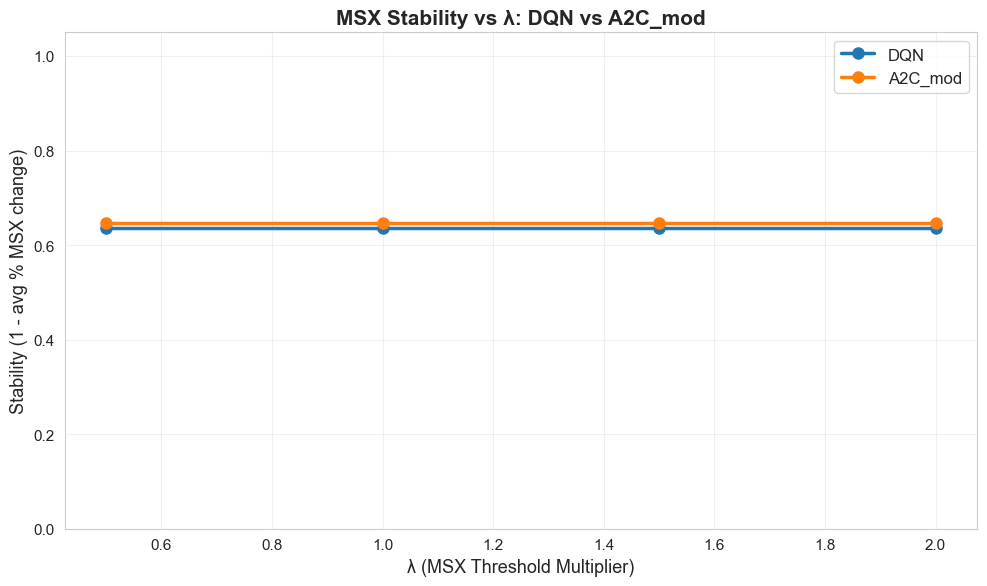

✅ Saved: ablation_stability_vs_lambda.png


In [38]:
# ============================================================
# PLOT 1: Stability vs λ — DQN vs A2C
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6))

for agent_name in AGENT_NAMES:
    subset = df_ablation[(df_ablation['agent'] == agent_name) &
                (df_ablation['xai_config'].isin(['RDX_only', 'Combined'])) &
                (df_ablation['Stability'].notna())]
    if subset.empty:
        continue
    grouped = subset.groupby('lambda')['Stability'].mean()
    ax.plot(grouped.index, grouped.values,
            marker='o', linewidth=2.5, markersize=8,
            label=agent_name)

ax.set_xlabel('λ (MSX Threshold Multiplier)', fontsize=13)
ax.set_ylabel('Stability (1 - avg % MSX change)', fontsize=13)
ax.set_title('MSX Stability vs λ: DQN vs A2C_mod', fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig('ablation_stability_vs_lambda.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: ablation_stability_vs_lambda.png")

### 5.2 Heatmap: CAS (Agent × Scenario) — Combined Config

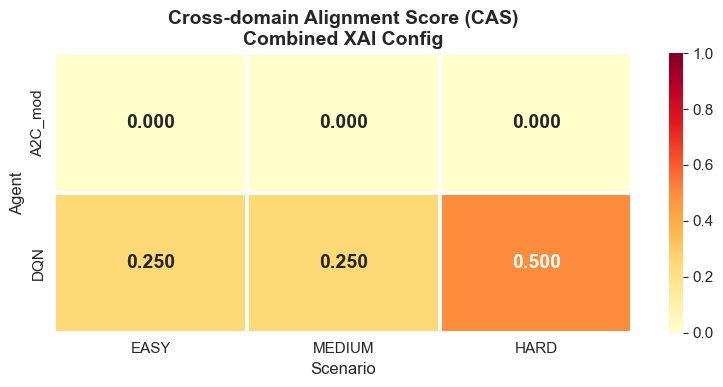

✅ Saved: ablation_cas_heatmap.png


In [40]:
# ============================================================
# PLOT 2: CAS Heatmap — Agent × Scenario (Combined config)
# ============================================================
cas_data = df_ablation[(df_ablation['xai_config'] == 'Combined') & (df_ablation['CAS'].notna())]

if not cas_data.empty:
    pivot_cas = cas_data.pivot_table(values='CAS',
                                      index='agent',
                                      columns='scenario',
                                      aggfunc='mean')
    # Reorder columns
    col_order = [c for c in ['EASY', 'MEDIUM', 'HARD'] if c in pivot_cas.columns]
    pivot_cas = pivot_cas[col_order]

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.heatmap(pivot_cas, annot=True, fmt='.3f', cmap='YlOrRd',
                vmin=0, vmax=1, linewidths=1.5, ax=ax,
                annot_kws={'fontsize': 14, 'fontweight': 'bold'})
    ax.set_title('Cross-domain Alignment Score (CAS)\nCombined XAI Config',
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Agent', fontsize=12)
    ax.set_xlabel('Scenario', fontsize=12)

    plt.tight_layout()
    plt.savefig('ablation_cas_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Saved: ablation_cas_heatmap.png")
else:
    print("⚠️ No CAS data available for Combined config")

### 5.3 Stacked Area Chart: Dominance Ratio of Reward Components

TypeError: 'NoneType' object is not iterable

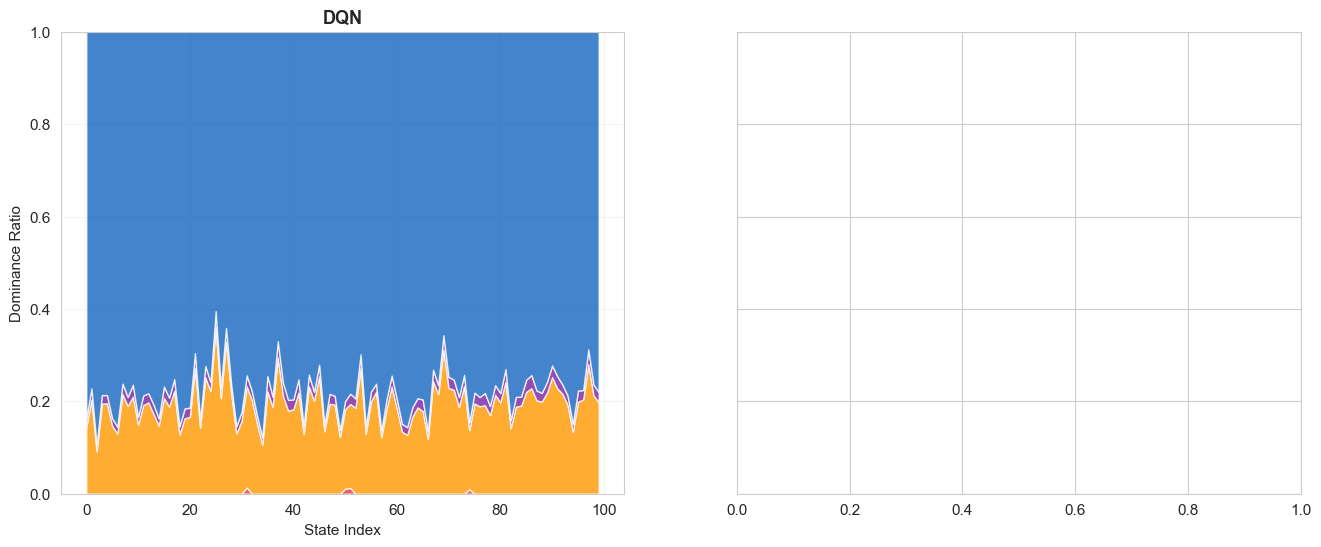

In [41]:
# ============================================================
# PLOT 3: Stacked Area — Reward Component Dominance over States
# Uses MEDIUM scenario, both agents
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

colors = ['#E53935', '#FF9800', '#7B1FA2', '#1565C0']

for ax_idx, agent_name in enumerate(AGENT_NAMES):
    ax = axes[ax_idx]
    s_flat, s_pp, x_vs = scenario_states['MEDIUM']
    n = min(100, s_flat.shape[0])  # limit for clarity

    comp_matrix = np.zeros((n, 4))  # [n_states, 4 objectives]

    for t in range(n):
        if agent_name == 'DQN':
            dq, _, _ = rdx_dqn(agents['q_network'], s_flat[t], x_vs[t])
        else:
            dq, _, _ = rdx_a2c(agents['actor'], agents['critic'], s_pp[t], x_vs[t])

        for k, obj in enumerate(OBJECTIVES):
            comp_matrix[t, k] = np.mean(np.abs(dq[obj]))

    # Normalize to proportions
    row_sums = comp_matrix.sum(axis=1, keepdims=True) + 1e-8
    comp_pct = comp_matrix / row_sums  # [n, 4]

    x_axis = np.arange(n)
    ax.stackplot(x_axis, comp_pct.T, labels=OBJECTIVES if ax_idx == 0 else None,
                 colors=colors, alpha=0.8)
    ax.set_title(f'{agent_name}', fontsize=13, fontweight='bold')
    ax.set_xlabel('State Index')
    if ax_idx == 0:
        ax.set_ylabel('Dominance Ratio')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.2)

axes[0].legend(loc='upper left', fontsize=9, ncol=2)
plt.suptitle('Reward Component Dominance Ratio Across States (MEDIUM)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('ablation_dominance_ratio.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: ablation_dominance_ratio.png")

### 5.4 Additional: OCS Comparison and MSX Size Distribution

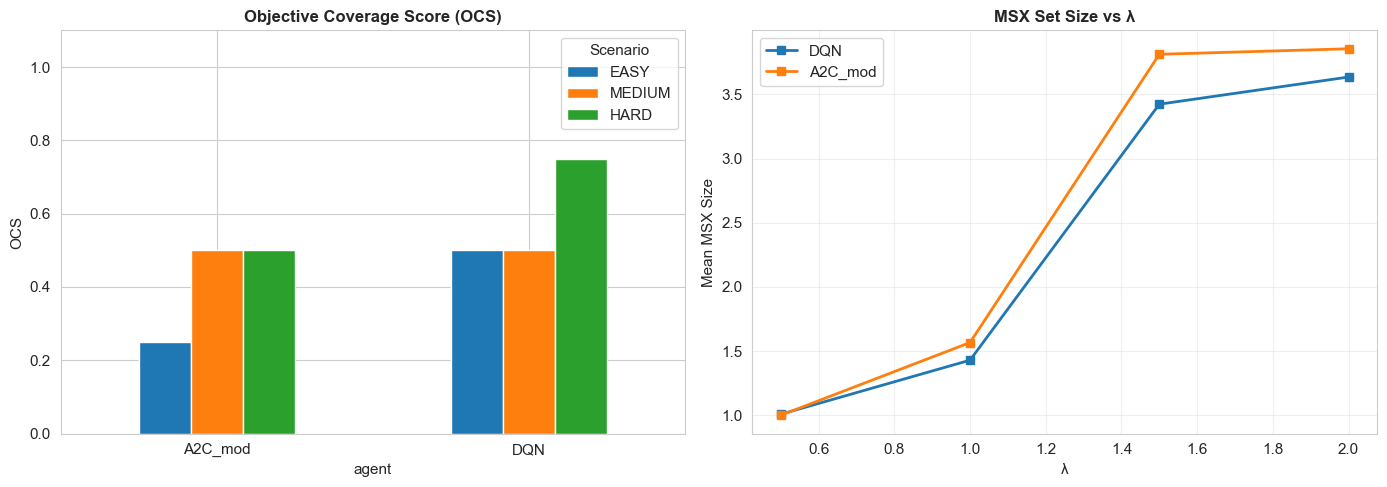

✅ Saved: ablation_ocs_msx.png


In [43]:
# ============================================================
# PLOT 4: OCS Comparison across configs
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# OCS by agent and config
ocs_data = df_ablation[df_ablation['OCS'].notna()]
if not ocs_data.empty:
    pivot_ocs = ocs_data.pivot_table(values='OCS',
                                      index=['agent'],
                                      columns=['scenario'],
                                      aggfunc='mean')
    col_order = [c for c in ['EASY', 'MEDIUM', 'HARD'] if c in pivot_ocs.columns]
    pivot_ocs[col_order].plot(kind='bar', ax=axes[0], rot=0)
    axes[0].set_title('Objective Coverage Score (OCS)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('OCS')
    axes[0].legend(title='Scenario')
    axes[0].set_ylim(0, 1.1)

# MSX size by lambda
msx_data = df_ablation[df_ablation['MSX_size_mean'].notna()]
if not msx_data.empty:
    for agent_name in AGENT_NAMES:
        subset = msx_data[msx_data['agent'] == agent_name]
        grouped = subset.groupby('lambda')['MSX_size_mean'].mean()
        axes[1].plot(grouped.index, grouped.values,
                     marker='s', linewidth=2, label=agent_name)
    axes[1].set_xlabel('λ')
    axes[1].set_ylabel('Mean MSX Size')
    axes[1].set_title('MSX Set Size vs λ', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ablation_ocs_msx.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: ablation_ocs_msx.png")

## Step 6: Sensitivity Analysis

### Mục tiêu
1. **Sinh dữ liệu test** cho 3 kịch bản EASY / MEDIUM / HARD bằng cách scale
   `x` (inventory), `sales`, và `waste_rate` theo tỷ lệ quy định.
2. **Giả lập thay đổi trọng số RDX**: Duyệt qua từng component ($w_s, w_h, w_w, w_o$),
   nhân RDX của nó với $\lambda \in \{0.5, 1.0, 1.5, 2.0\}$ trong khi giữ nguyên các RDX khác.
3. **Trực quan hóa**: Line chart Mean RDX theo λ + Stacked Bar chart MSX inclusion frequency.

### Scenario Data Scaling
| Parameter | EASY | MEDIUM | HARD |
|-----------|------|--------|------|
| `x` (inventory) scale | 30% | 60% | 90% |
| `sales` scale | 20% | 50% | 80% |
| `waste_rate` | 1% | 5% | 15% |

### 6.1 Sinh dữ liệu test cho các kịch bản

In [44]:
# ============================================================
# SENSITIVITY SCENARIO DATA GENERATION
# ============================================================
# Scale factors theo yêu cầu:
#   EASY:   x=30%, sales=20%, waste_rate=1%
#   MEDIUM: x=60%, sales=50%, waste_rate=5%
#   HARD:   x=90%, sales=80%, waste_rate=15%

SENSITIVITY_SCENARIOS = {
    'EASY':   {'x_scale': 0.30, 'sales_scale': 0.20, 'waste_rate': 0.01},
    'MEDIUM': {'x_scale': 0.60, 'sales_scale': 0.50, 'waste_rate': 0.05},
    'HARD':   {'x_scale': 0.90, 'sales_scale': 0.80, 'waste_rate': 0.15},
}

def generate_scenario_data(scenario_params, n_states=N_STATES):
    """
    Sinh tập test data cho từng kịch bản Sensitivity Analysis.

    Khác với collect_states() ở Step 4:
      - x_init được SCALE theo x_scale (mô phỏng mức tồn kho ban đầu khác nhau)
      - sales được SCALE theo sales_scale (mô phỏng nhu cầu khác nhau)
      - waste_rate thay đổi theo kịch bản (không dùng WASTE_RATE toàn cục)

    Args:
        scenario_params: dict với 'x_scale', 'sales_scale', 'waste_rate'
        n_states: số lượng states cần sinh

    Returns:
        states_flat: np.ndarray [n_states, 660] — cho DQN
        states_pp:   np.ndarray [n_states, P, 3] — cho A2C (per-product)
        x_vecs:      np.ndarray [n_states, P]    — inventory vectors thô
    """
    x_sc  = scenario_params['x_scale']
    s_sc  = scenario_params['sales_scale']
    wr    = scenario_params['waste_rate']

    # Scale initial inventory
    x = (x_init * x_sc).astype(np.float32)

    states_flat, states_pp, x_vecs = [], [], []

    for t in range(min(n_states, T_MAX)):
        # Scale sales
        sales = (all_sales[t] * s_sc).astype(np.float32)
        # Waste with scenario-specific rate
        q = (wr * x).astype(np.float32)

        # Build state representations
        s_pp   = np.stack([x, sales, q], axis=1).astype(np.float32)      # [P, 3]
        s_flat = np.concatenate([x, sales, q]).astype(np.float32)  # [660]

        states_pp.append(s_pp)
        states_flat.append(s_flat)
        x_vecs.append(x.copy())

        # Step environment forward (A2C policy)
        probs = agents['actor'](s_pp).numpy()
        a_idx = np.argmax(probs, axis=1)
        u     = ACTION_SPACE[a_idx]
        x_u   = np.minimum(1, x + u)
        x     = np.maximum(0, x_u - sales).astype(np.float32)

    return (np.array(states_flat, np.float32),
            np.array(states_pp, np.float32),
            np.array(x_vecs, np.float32))

# Generate data for each sensitivity scenario
sens_data = {}
for scn_name, scn_params in SENSITIVITY_SCENARIOS.items():
    sens_data[scn_name] = generate_scenario_data(scn_params)
    n = sens_data[scn_name][0].shape[0]
    print(f"  {scn_name}: {n} states | "
          f"x_scale={scn_params['x_scale']:.0%}, "
          f"sales_scale={scn_params['sales_scale']:.0%}, "
          f"waste_rate={scn_params['waste_rate']:.0%}")

print("\n✅ Sensitivity scenario data generated")

  EASY: 496 states | x_scale=30%, sales_scale=20%, waste_rate=1%
  MEDIUM: 496 states | x_scale=60%, sales_scale=50%, waste_rate=5%
  HARD: 496 states | x_scale=90%, sales_scale=80%, waste_rate=15%

✅ Sensitivity scenario data generated


### 6.2 Giả lập thay đổi trọng số RDX

Ý tưởng: Với mỗi component $w_k \in \{w_s, w_h, w_w, w_o\}$:
- Tính RDX gốc: $\Delta Q^k$ cho tất cả 4 objectives
- Nhân $\Delta Q^k$ của component đang xét với $\lambda$, giữ nguyên các component khác
- Quan sát: Mean RDX thay đổi thế nào? MSX set thay đổi thế nào?

Mapping ký hiệu:
- $w_s$ → `stockout` (z)
- $w_h$ → `overstock`
- $w_w$ → `waste` (q)
- $w_o$ → `quantile` (quan)

In [45]:
# ============================================================
# PERTURB RDX WEIGHTS & COLLECT SENSITIVITY METRICS
# ============================================================

# Component weights notation: w_s=service(1-z), w_h=holding(overstock), w_w=waste, w_o=order(quantile)
WEIGHT_LABELS = {
    'stockout':  '$w_s$ (service)',
    'overstock': '$w_h$ (holding)',
    'waste':     '$w_w$ (Waste)',
    'quantile':  '$w_o$ (order)',
}

# def perturb_rdx_weights(delta_q_original, target_component, lam):
#     """
#     Giả lập thay đổi trọng số của MỘT component RDX.

#     Nhân ΔQ^k của target_component với λ, giữ nguyên các component khác.
#     → Mô phỏng việc "tăng/giảm tầm quan trọng" của một mục tiêu.

#     Args:
#         delta_q_original: dict[str, np.ndarray[P]] — RDX gốc
#         target_component: str — component cần thay đổi ('stockout', 'overstock', ...)
#         lam: float — hệ số scale

#     Returns:
#         delta_q_perturbed: dict[str, np.ndarray[P]] — RDX đã điều chỉnh
#     """
#     # perturbed = {}
#     # for obj in OBJECTIVES:
#     #     if obj == target_component:
#     #         perturbed[obj] = delta_q_original[obj] * lam   # Scale component này
#     #     else:
#     #         perturbed[obj] = delta_q_original[obj].copy()   # Giữ nguyên
#     # return perturbed
#      # Bước 1: Scale target component
#     perturbed = {}
#     for obj in OBJECTIVES:
#         if obj == target_component:
#             perturbed[obj] = delta_q_original[obj] * lam
#         else:
#             perturbed[obj] = delta_q_original[obj].copy()

#     # Bước 2: Tính tổng |ΔQ| trước và sau
#     orig_total = sum(np.sum(np.abs(delta_q_original[obj])) for obj in OBJECTIVES)
#     new_total  = sum(np.sum(np.abs(perturbed[obj])) for obj in OBJECTIVES)

#     # Bước 3: Re-normalize để giữ tổng = const
#     scale_factor = orig_total / (new_total + 1e-12)
#     for obj in OBJECTIVES:
#         perturbed[obj] = perturbed[obj] * scale_factor

#     return perturbed
def perturb_rdx_weights(delta_q_original, target_component, lam):
    """
    SIMPLIFIED VERSION: Chỉ scale target component, KHÔNG normalize.
    
    Rationale:
      - We WANT to see magnitude difference when λ changes
      - Normalization hides this effect
      - MSX computation already uses relative importance (via sorting)
    """
    perturbed = {}
    for obj in OBJECTIVES:
        if obj == target_component:
            perturbed[obj] = delta_q_original[obj] * lam
        else:
            perturbed[obj] = delta_q_original[obj].copy()
    
    return perturbed  # ← NO NORMALIZATION!

# ── Run sensitivity analysis ───────────────────────────────────
SENS_LAMBDAS = [0.5, 1, 1.5, 2]

sensitivity_results = []

for agent_name in AGENT_NAMES:
    for scn_name in SENSITIVITY_SCENARIOS:
        s_flat, s_pp, x_vs = sens_data[scn_name]
        n = s_flat.shape[0]

        # Compute baseline RDX (average over sampled states)
        rdx_base = {obj: np.zeros(NUM_PRODUCTS) for obj in OBJECTIVES}
        qgap_base = np.zeros(NUM_PRODUCTS)
        sample_idx = np.arange(0, n, max(1, n // 50))

        for idx in sample_idx:
            if agent_name == 'DQN':
                dq, _, qg = rdx_dqn(agents['q_network'], s_flat[idx], x_vs[idx])
            else:
                dq, _, qg = rdx_a2c(agents['actor'], agents['critic'],
                                 s_pp[idx], x_vs[idx])
            for obj in OBJECTIVES:
                rdx_base[obj] += dq[obj]
            qgap_base += qg
        for obj in OBJECTIVES:
            rdx_base[obj] /= len(sample_idx)
        qgap_base /= len(sample_idx)

        # Perturb each component independently
        for target_comp in OBJECTIVES:
            for lam in SENS_LAMBDAS:
                dq_perturbed = perturb_rdx_weights(rdx_base, target_comp, lam)

                # Mean absolute RDX for perturbed component
                mean_rdx = float(np.mean(np.abs(dq_perturbed[target_comp])))

                # MSX inclusion: how often does target_comp appear in MSX?
                # Use baseline q_gap (unchanged by perturbation)
                msx_sets, _ = compute_msx(dq_perturbed, qgap_base, lam=1.0)  # MSX threshold fixed at 1.0
                inclusion_rate = sum(1 for ms in msx_sets if target_comp in ms) / NUM_PRODUCTS

                sensitivity_results.append({
                    'agent':     agent_name,
                    'scenario':  scn_name,
                    'component': target_comp,
                    'w_label':   WEIGHT_LABELS[target_comp],
                    'lambda':    lam,
                    'mean_rdx':  mean_rdx,
                    'msx_inclusion':  inclusion_rate,
                })

    print(f"  Sensitivity done for {agent_name}")

df_sens = pd.DataFrame(sensitivity_results)
df_sens.to_csv('sensitivity_results.csv', index=False)
print(f"\n✅ Sensitivity analysis: {len(df_sens)} rows saved to sensitivity_results.csv")

df_sens.head(50)


  Sensitivity done for DQN
  Sensitivity done for A2C_mod

✅ Sensitivity analysis: 96 rows saved to sensitivity_results.csv


,agent,scenario,component,w_label,lambda,mean_rdx,msx_inclusion
0,DQN,EASY,stockout,$w_s$ (service),0.5,0.000000,0.000000
1,DQN,EASY,stockout,$w_s$ (service),1.0,0.000000,0.000000
2,DQN,EASY,stockout,$w_s$ (service),1.5,0.000000,0.000000
3,DQN,EASY,stockout,$w_s$ (service),2.0,0.000000,0.000000
4,DQN,EASY,overstock,$w_h$ (holding),0.5,0.004002,0.118182
5,DQN,EASY,overstock,$w_h$ (holding),1.0,0.008005,0.131818
6,DQN,EASY,overstock,$w_h$ (holding),1.5,0.012007,0.131818
7,DQN,EASY,overstock,$w_h$ (holding),2.0,0.016009,0.131818
8,DQN,EASY,waste,$w_w$ (Waste),0.5,0.000352,0.000000
9,DQN,EASY,waste,$w_w$ (Waste),1.0,0.000705,0.000000


### 6.3 Visualization: Sensitivity Analysis

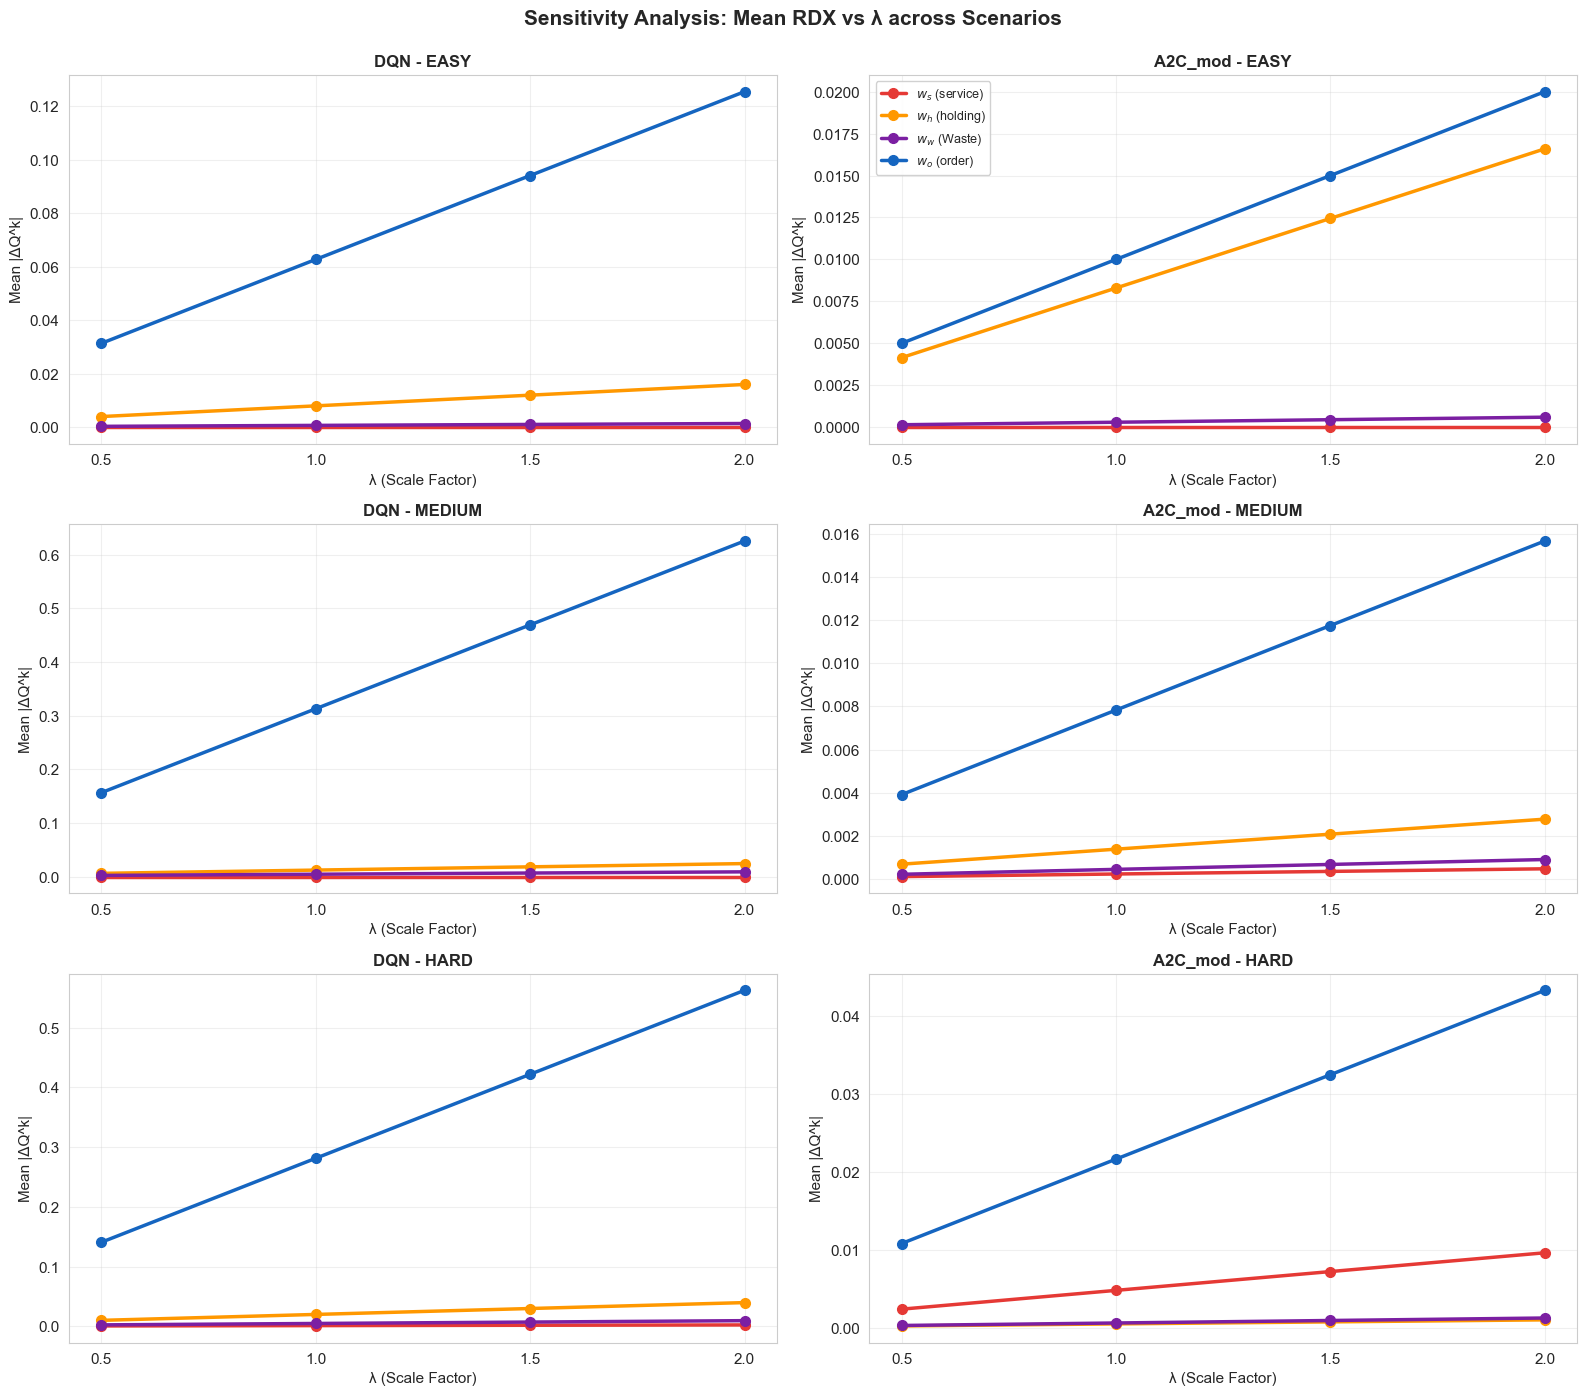

✅ Saved: sensitivity_mean_rdx_vs_lambda_by_scenario.png


In [49]:
# ============================================================
# PLOT SA-1: Line Chart — Mean |ΔQ^k| vs λ (per scenario & component)
# ============================================================
# Grid: 3 scenarios (rows) x 2 agents (cols)
# Mỗi subplot: 4 đường cho 4 components
# Cho thấy RDX magnitude thay đổi thế nào khi scale weight TRONG TỪNG SCENARIO

comp_colors = {
    'stockout':  '#E53935',
    'overstock': '#FF9800',
    'waste':     '#7B1FA2',
    'quantile':  '#1565C0',
}

scenario_order = ['EASY', 'MEDIUM', 'HARD']
fig, axes = plt.subplots(3, 2, figsize=(16, 14), sharey=False)

for row_idx, scn in enumerate(scenario_order):
    for col_idx, agent_name in enumerate(AGENT_NAMES):
        ax = axes[row_idx, col_idx]
        
        for comp in OBJECTIVES:
            subset = df_sens[(df_sens['agent'] == agent_name) &
                             (df_sens['component'] == comp) &
                             (df_sens['scenario'] == scn)]
            if subset.empty:
                continue
            
            # Group by lambda for this specific scenario
            grouped = subset.groupby('lambda')['mean_rdx'].mean()
            
            ax.plot(grouped.index, grouped.values,
                    marker='o', linewidth=2.5, markersize=7,
                    color=comp_colors[comp],
                    label=WEIGHT_LABELS[comp])
        
        ax.set_xlabel('λ (Scale Factor)', fontsize=11)
        ax.set_ylabel('Mean |ΔQ^k|', fontsize=11)
        ax.set_title(f'{agent_name} - {scn}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(SENS_LAMBDAS)
        
        # Legend only on top-right subplot
        if row_idx == 0 and col_idx == 1:
            ax.legend(fontsize=9, loc='upper left', framealpha=0.9)

plt.suptitle('Sensitivity Analysis: Mean RDX vs λ across Scenarios',
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('sensitivity_mean_rdx_vs_lambda_by_scenario.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: sensitivity_mean_rdx_vs_lambda_by_scenario.png")

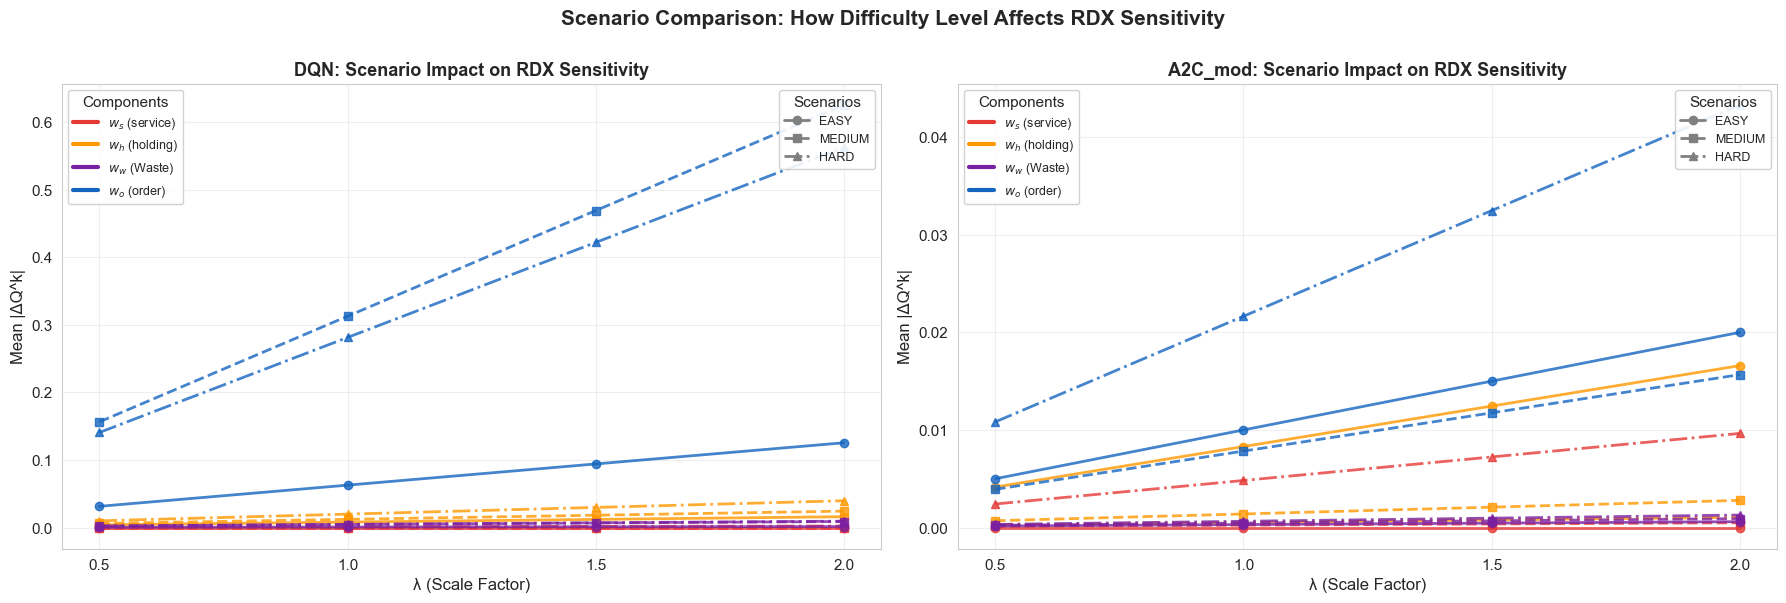

✅ Saved: sensitivity_scenario_comparison.png


In [50]:
# ============================================================
# PLOT SA-1b: Scenario Comparison (Alternative View)
# ============================================================
# Mỗi subplot = 1 agent
# Mỗi component = 1 màu
# Mỗi scenario = 1 line style
# Cho phép so sánh TRỰC TIẾP ảnh hưởng của scenario difficulty

scenario_styles = {
    'EASY':   {'linestyle': '-',  'marker': 'o', 'alpha': 0.8},
    'MEDIUM': {'linestyle': '--', 'marker': 's', 'alpha': 0.8},
    'HARD':   {'linestyle': '-.', 'marker': '^', 'alpha': 0.8},
}

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for ax_idx, agent_name in enumerate(AGENT_NAMES):
    ax = axes[ax_idx]
    
    for comp in OBJECTIVES:
        for scn in scenario_order:
            subset = df_sens[(df_sens['agent'] == agent_name) &
                             (df_sens['component'] == comp) &
                             (df_sens['scenario'] == scn)]
            if subset.empty:
                continue
            
            grouped = subset.groupby('lambda')['mean_rdx'].mean()
            
            label = f"{WEIGHT_LABELS[comp]} ({scn})" if comp == OBJECTIVES[0] else None
            ax.plot(grouped.index, grouped.values,
                    color=comp_colors[comp],
                    linestyle=scenario_styles[scn]['linestyle'],
                    marker=scenario_styles[scn]['marker'],
                    linewidth=2.0, markersize=6,
                    alpha=scenario_styles[scn]['alpha'],
                    label=label if comp == OBJECTIVES[0] else "")
    
    ax.set_xlabel('λ (Scale Factor)', fontsize=12)
    ax.set_ylabel('Mean |ΔQ^k|', fontsize=12)
    ax.set_title(f'{agent_name}: Scenario Impact on RDX Sensitivity', 
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(SENS_LAMBDAS)
    
    # Custom legend showing both components and scenarios
    from matplotlib.lines import Line2D
    comp_handles = [Line2D([0], [0], color=comp_colors[obj], linewidth=3, label=WEIGHT_LABELS[obj])
                    for obj in OBJECTIVES]
    scn_handles = [Line2D([0], [0], color='gray', linestyle=scenario_styles[scn]['linestyle'],
                          marker=scenario_styles[scn]['marker'], linewidth=2, 
                          markersize=6, label=scn) 
                   for scn in scenario_order]
    
    first_legend = ax.legend(handles=comp_handles, loc='upper left', 
                             title='Components', fontsize=9, framealpha=0.9)
    ax.add_artist(first_legend)
    ax.legend(handles=scn_handles, loc='upper right',
              title='Scenarios', fontsize=9, framealpha=0.9)

plt.suptitle('Scenario Comparison: How Difficulty Level Affects RDX Sensitivity',
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('sensitivity_scenario_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: sensitivity_scenario_comparison.png")

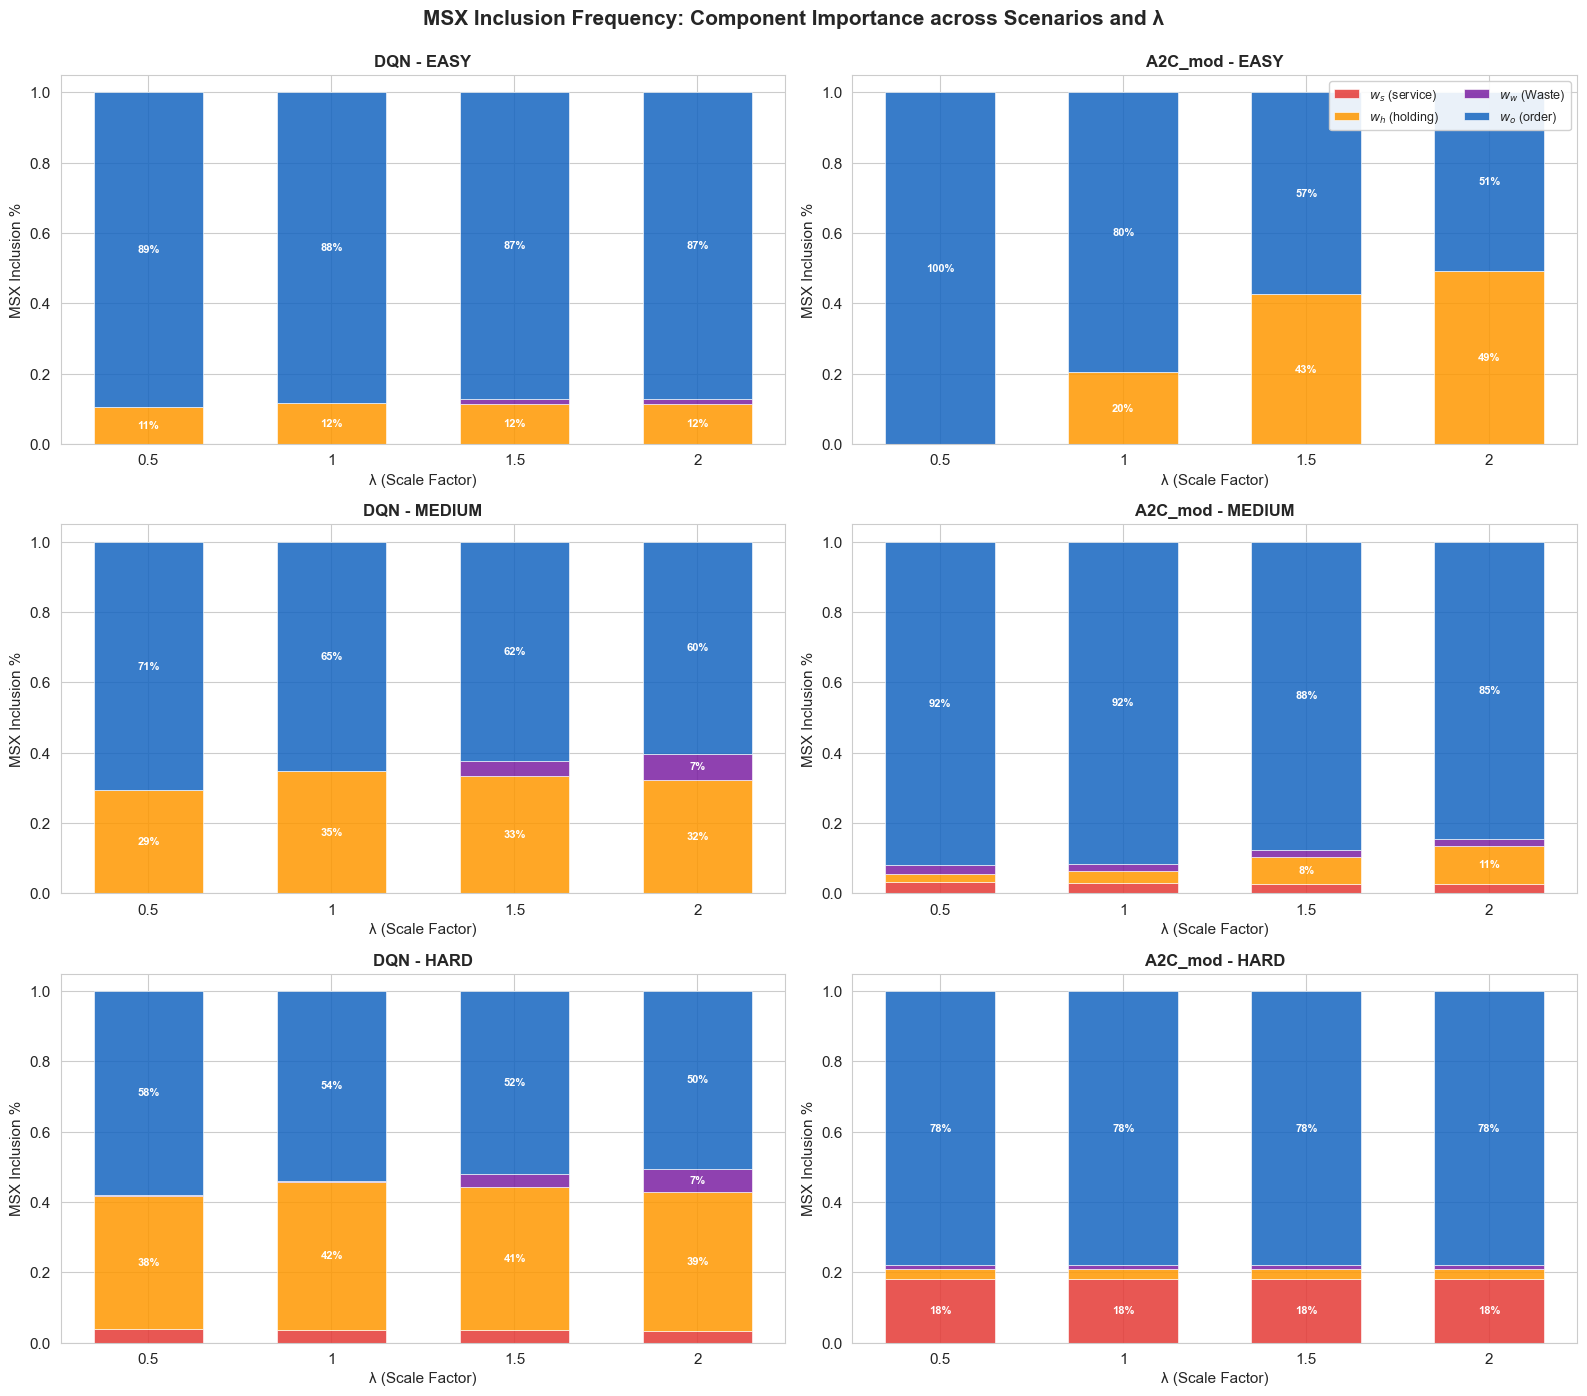

✅ Saved: sensitivity_msx_inclusion_by_scenario.png


In [51]:
# ============================================================
# PLOT SA-2: MSX Inclusion Frequency by Scenario
# ============================================================
# Grid: 3 scenarios (rows) x 2 agents (cols)
# Mỗi subplot: Stacked bar chart showing component inclusion rates

scenario_order = ['EASY', 'MEDIUM', 'HARD']
bar_colors = ['#E53935', '#FF9800', '#7B1FA2', '#1565C0']

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

for row_idx, scn in enumerate(scenario_order):
    for col_idx, agent_name in enumerate(AGENT_NAMES):
        ax = axes[row_idx, col_idx]
        
        # Build inclusion matrix for this scenario
        inclusion_matrix = np.zeros((len(OBJECTIVES), len(SENS_LAMBDAS)))
        
        for k, comp in enumerate(OBJECTIVES):
            for j, lam in enumerate(SENS_LAMBDAS):
                subset = df_sens[(df_sens['agent'] == agent_name) &
                                 (df_sens['component'] == comp) &
                                 (df_sens['scenario'] == scn) &
                                 (df_sens['lambda'] == lam)]
                if not subset.empty:
                    inclusion_matrix[k, j] = subset['msx_inclusion'].mean()
        
        # Normalize to 100% stacked
        col_sums = inclusion_matrix.sum(axis=0, keepdims=True)
        col_sums = np.where(col_sums == 0, 1, col_sums)
        inc_pct = inclusion_matrix / col_sums
        
        x_pos = np.arange(len(SENS_LAMBDAS))
        bar_width = 0.6
        bottom = np.zeros(len(SENS_LAMBDAS))
        
        for k, comp in enumerate(OBJECTIVES):
            bars = ax.bar(x_pos, inc_pct[k], bar_width, bottom=bottom,
                          color=bar_colors[k], label=WEIGHT_LABELS[comp] if row_idx == 0 and col_idx == 1 else "",
                          alpha=0.85, edgecolor='white', linewidth=0.5)
            
            # Annotate percentages
            for j in range(len(SENS_LAMBDAS)):
                if inc_pct[k, j] > 0.05:
                    ax.text(x_pos[j], bottom[j] + inc_pct[k, j] / 2,
                            f'{inc_pct[k, j]:.0%}',
                            ha='center', va='center', fontsize=8, 
                            fontweight='bold', color='white')
            bottom += inc_pct[k]
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels([f'{v}' for v in SENS_LAMBDAS])
        ax.set_xlabel('λ (Scale Factor)', fontsize=11)
        ax.set_ylabel('MSX Inclusion %', fontsize=11)
        ax.set_title(f'{agent_name} - {scn}', fontsize=12, fontweight='bold')
        ax.set_ylim(0, 1.05)
        
        # Legend only on top-right
        if row_idx == 0 and col_idx == 1:
            ax.legend(fontsize=9, loc='upper right', ncol=2, framealpha=0.9)

plt.suptitle('MSX Inclusion Frequency: Component Importance across Scenarios and λ',
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('sensitivity_msx_inclusion_by_scenario.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: sensitivity_msx_inclusion_by_scenario.png")

In [48]:
# ============================================================
# SENSITIVITY SUMMARY TABLE
# ============================================================
print("=" * 70)
print("SENSITIVITY ANALYSIS SUMMARY")
print("=" * 70)

# Pivot: Mean RDX by (agent, component) vs lambda
pivot_rdx = df_sens.pivot_table(
    values='mean_rdx',
    index=['agent', 'component'],
    columns='lambda',
    aggfunc='mean'
)
print("\n📊 Mean |ΔQ^k| across λ values:")
print(pivot_rdx.round(4).to_string())

# Pivot: MSX inclusion by (agent, component) vs lambda
pivot_inc = df_sens.pivot_table(
    values='msx_inclusion',
    index=['agent', 'component'],
    columns='lambda',
    aggfunc='mean'
)
print("\n📊 MSX Inclusion Rate across λ values:")
print(pivot_inc.round(3).to_string())

# Key insight: which component is most sensitive?
for agent_name in AGENT_NAMES:
    agent_data = df_sens[df_sens['agent'] == agent_name]
    rdx_range = agent_data.groupby('component')['mean_rdx'].agg(['min', 'max'])
    rdx_range['sensitivity'] = rdx_range['max'] - rdx_range['min']
    most_sensitive = rdx_range['sensitivity'].idxmax()
    print(f"\n🔍 {agent_name}: Most sensitive component = {most_sensitive} "
          f"(range = {rdx_range.loc[most_sensitive, 'sensitivity']:.4f})")

SENSITIVITY ANALYSIS SUMMARY

📊 Mean |ΔQ^k| across λ values:
lambda                0.5     1.0     1.5     2.0
agent   component                                
A2C_mod overstock  0.0017  0.0034  0.0051  0.0068
        quantile   0.0066  0.0132  0.0197  0.0263
        stockout   0.0008  0.0017  0.0025  0.0034
        waste      0.0002  0.0005  0.0007  0.0009
DQN     overstock  0.0067  0.0133  0.0200  0.0267
        quantile   0.1095  0.2190  0.3285  0.4380
        stockout   0.0002  0.0004  0.0006  0.0008
        waste      0.0016  0.0033  0.0049  0.0066

📊 MSX Inclusion Rate across λ values:
lambda               0.5    1.0    1.5    2.0
agent   component                            
A2C_mod overstock  0.020  0.092  0.288  0.379
        quantile   0.641  0.927  1.000  1.000
        stockout   0.088  0.088  0.088  0.088
        waste      0.012  0.012  0.012  0.012
DQN     overstock  0.395  0.483  0.483  0.483
        quantile   1.000  1.000  1.000  1.000
        stockout   0.023  0.023 

## Summary & Interpretation

### How to Read Results

**OCS (Objective Coverage Score)**:
- High OCS → agent's decisions are driven by multiple reward objectives
- Low OCS → agent focuses narrowly on 1-2 objectives

**FCS (Feature Coverage Score)**:
- High FCS → model uses all input features (inventory, sales, waste) in decisions
- Low FCS → model relies on subset of features

**CAS (Cross-domain Alignment)**:
- High CAS → SHAP feature importances AGREE with RDX objective importances
- Low CAS → disconnect between what features the model uses and what objectives it optimizes

**Stability**:
- High Stability → MSX explanation is robust across threshold changes
- Low Stability → explanations are fragile, sensitive to hyperparameters

### Sensitivity Analysis Interpretation
- **Line chart (SA-1)**: Nếu đường dốc → component đó có ảnh hưởng mạnh lên giải thích
- **Stacked bar (SA-2)**: Nếu tỷ lệ phần trăm thay đổi nhiều → MSX nhạy cảm với trọng số

**For Reviewers**: The CAS metric is the key contribution — it bridges
the gap between feature-level (SHAP) and objective-level (RDX) explanations,
validating that the model's internal feature usage aligns with the reward
structure of the environment.